# Data z reálné jízdy (RSX-UM7)
> Zkoumání pro korelaci s realitou

### 📙 Importy

In [1]:
import pandas as pd
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
import ruptures as rpt
import importlib
from csv2geojson import prep
import json
from fastdtw import fastdtw
from dbrail2geojson import get_rail
from scipy.signal import savgol_filter
import numpy as np
from ipyleaflet import Map, basemaps, Polyline, basemap_to_tiles

pd.options.mode.chained_assignment = None

### 🌐 Globální nastavení a proměnné

In [2]:
PREP_GEOJSONS=False

processed_sections=[]

### ⬇️ Načtení souboru se surovými daty

In [3]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

df2 = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_09-04-10.csv") # Korekce pro začátek jízdy
# df2["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
# with open("/tmp/test.geojson", "w") as f:
#     f.write(geojson)

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')
Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


### 🔎 Náhled na akceleraci a rychlost v celém souboru

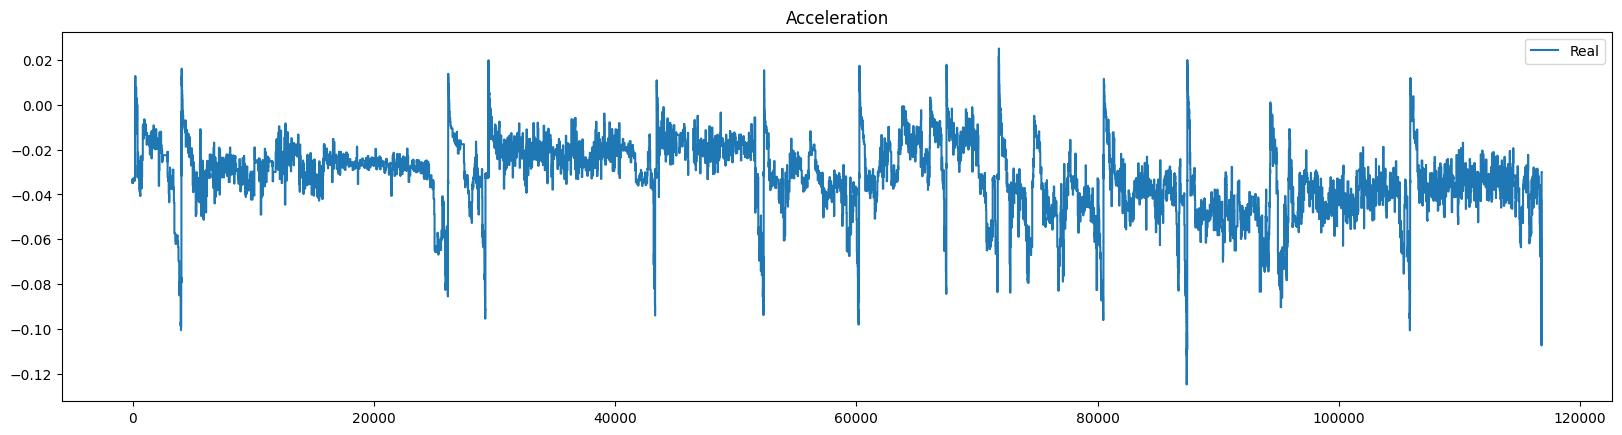

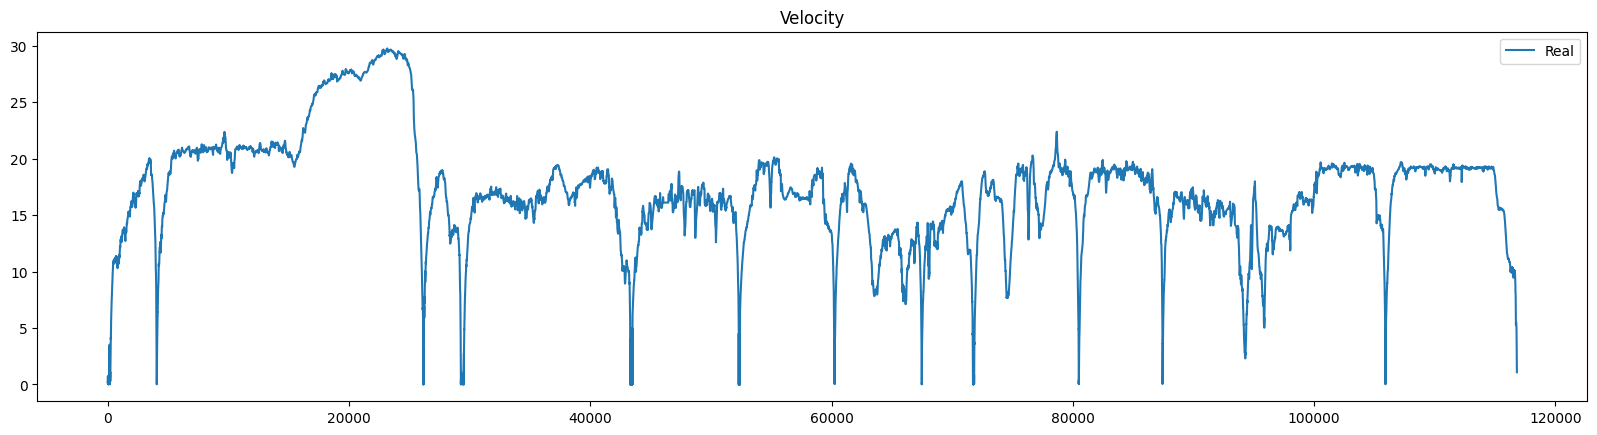

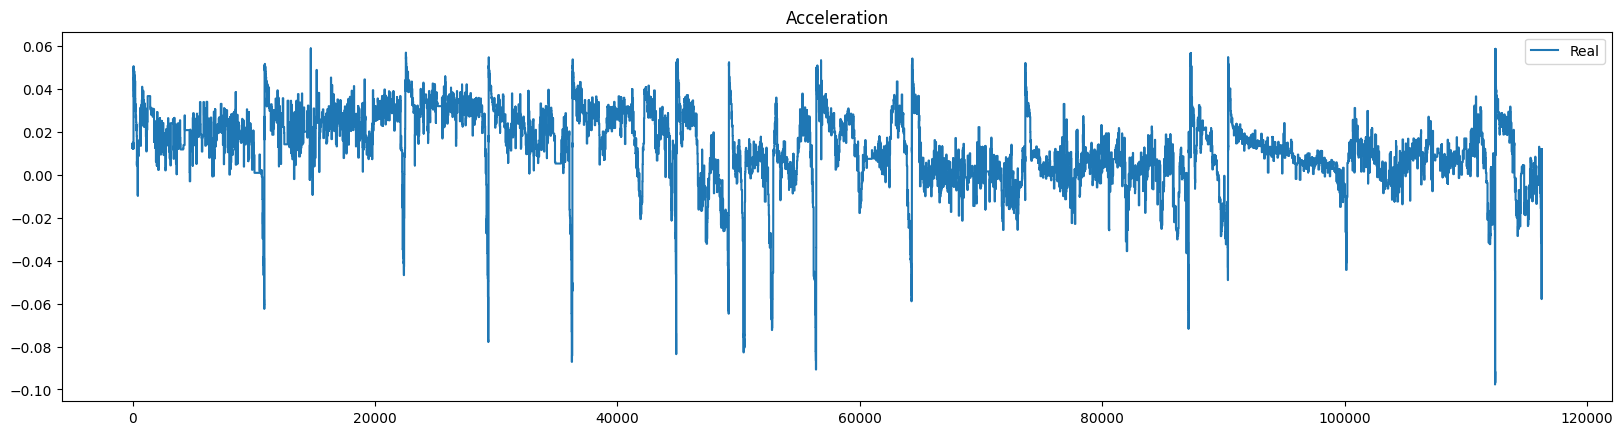

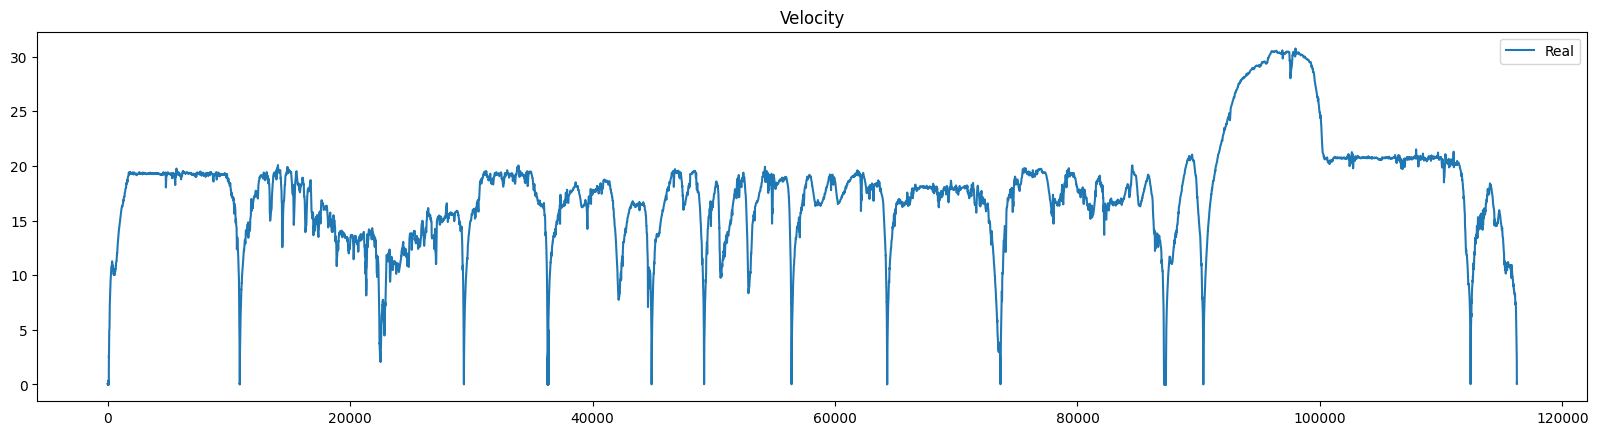

In [4]:
plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df2["cumulative_distance_m"], df2["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df2["cumulative_distance_m"], df2["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

### 🛠️ Funkce pro zpracování

In [5]:
def render_plot(title, x, ys, labels, linestyles=None, width=20, show_hline=False, legend_loc="upper left"):
    if linestyles is None:
        linestyles = ["solid"]*len(ys)
    plt.figure().set_figwidth(width)
    for i,y in enumerate(ys):
        plt.plot(x, y, linestyle=linestyles[i])
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc=legend_loc)
    if show_hline:
        plt.axhline(y=0, xmin=0.0, xmax=1.0, color="red", linestyle="--", lw=1)
    plt.show()

In [6]:
def map_velocity(df_measured, first_offset, velocity_fp, reverse=False):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    if not reverse:
        for tv in track_velocity:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]
    else:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            df_measured.loc[first_offset*1000 + (df_measured["cumulative_distance_m"]-first_dist) >= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

def infer_velocity(df_measured, penalty):
    # Getting velocity segments
    algo = rpt.Pelt(model="rbf").fit(df_measured["gps_speed"].values)
    result = algo.predict(pen=penalty)

    max_velocities = []
    prev_end = 0
    for i,r in enumerate(result):
        segment = df_measured["gps_speed"][prev_end:r]
        if len(df_measured["gps_speed"][result[i-1]:r]) < 100 and i != len(result)-1:
            continue
        prev_end = r
        max_velocities += [max(segment)] * len(segment)

    df_measured["track_velocity_m_s"] = max_velocities

In [7]:
def run_simulation(df_measured, geojson_path: str):
    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params = {
        'Recuperation coefficient': 0.6998270177197322,
        'Curve A': 226.0739452231682,
        'Curve B': 55.026751900632405,
        'Running a': 0.706437197926143,
        'Running b': 0.01899266921470387,
        'Running c': 0.008283331094691721,
        'Comfortable acceleration': 0.41725031534778388,
        'Elevation smoothing': 100,
        'Curve smoothing': 10
    }
    c.load_from_file(geojson_path)
    c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000

    # Running the simulation
    c.run()

    return c

In [8]:
def compare_data(df_measured, geojson_path: str):
    c = run_simulation(df_measured, geojson_path)

    # Plotting
    # render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    # Velocity deltas
    velocity_deltas = []
    # Get deltas
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)

    render_plot(
        "Velocity delta",
        c.series["dist_values"],
        [velocity_deltas],
        ["Delta"],
        ["solid"]
    )

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"],
    #     [df_measured["accel_proc_y"]],
    #     ["Real"]
    # )

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"],
    #     [c.series["acceleration_values"]],
    #     ["Simulation"]
    # )

    dtw = fastdtw(c.series["velocity_values"], df_measured["gps_speed"])[0]
    print("DTW:", dtw)

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

    # GPS info
    m = Map(
        basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
        center=((df_measured.iloc[0]['gps_latitude']+df_measured.iloc[-1]['gps_latitude'])/2, (df_measured.iloc[0]['gps_longitude']+df_measured.iloc[-1]['gps_longitude'])/2),
        zoom=12
    )
    line = Polyline(
        locations=df_measured[["gps_latitude", "gps_longitude"]].values.tolist(),
        color="green",
        fill=False
    )
    m.add_layer(line)
    return m

### 🛤️ Zpracované úseky

#### Opava západ ➡️ Krnov-Cvilín

unique velocities in km/h {80.52800674438477, 107.11000442504883, 100.52200469970704, 84.99800720214844}


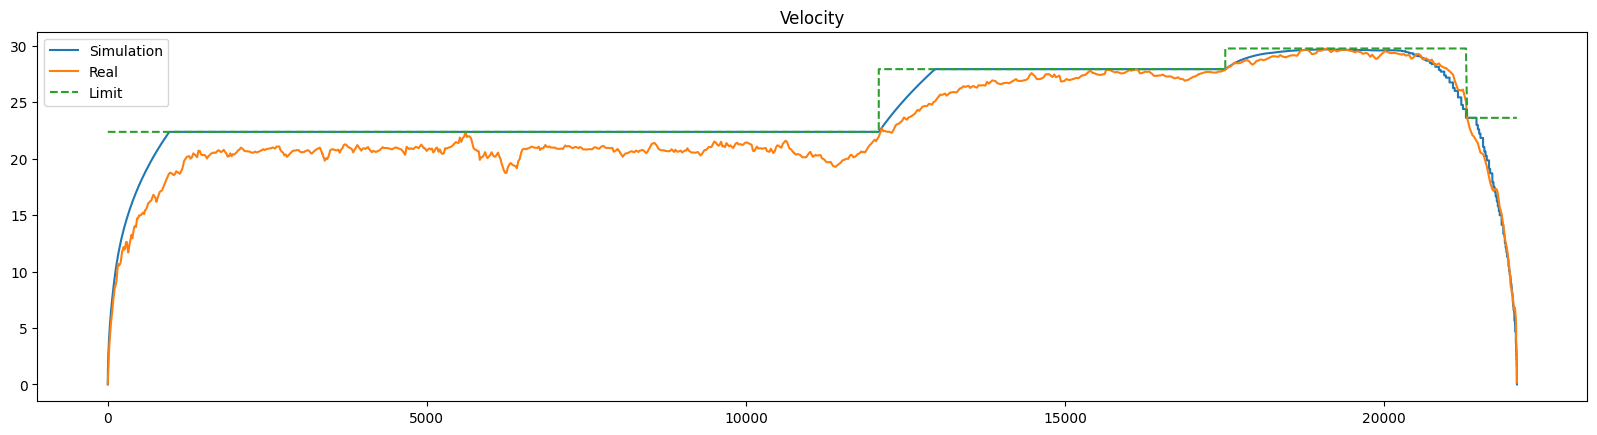

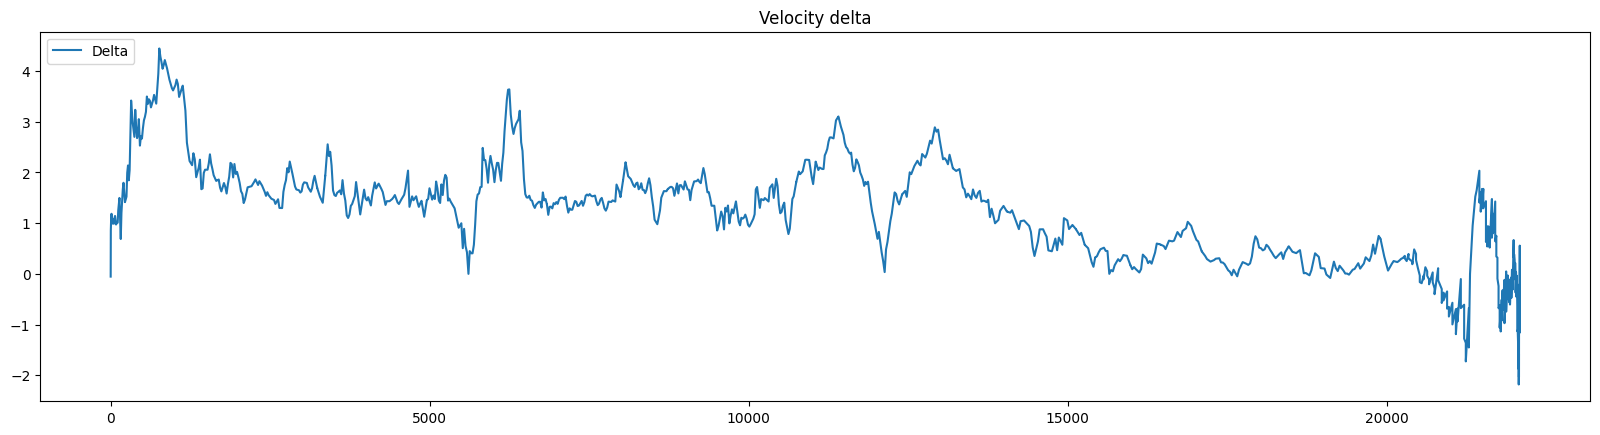

DTW: 1543.6783980248993


Map(center=[50.016578674316406, 17.80017852783203], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [9]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 112.329, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Krnov-Cvilín ➡️ Krnov

unique velocities in km/h {68.37500610351562, 37.11300086975098, 55.77700424194337}


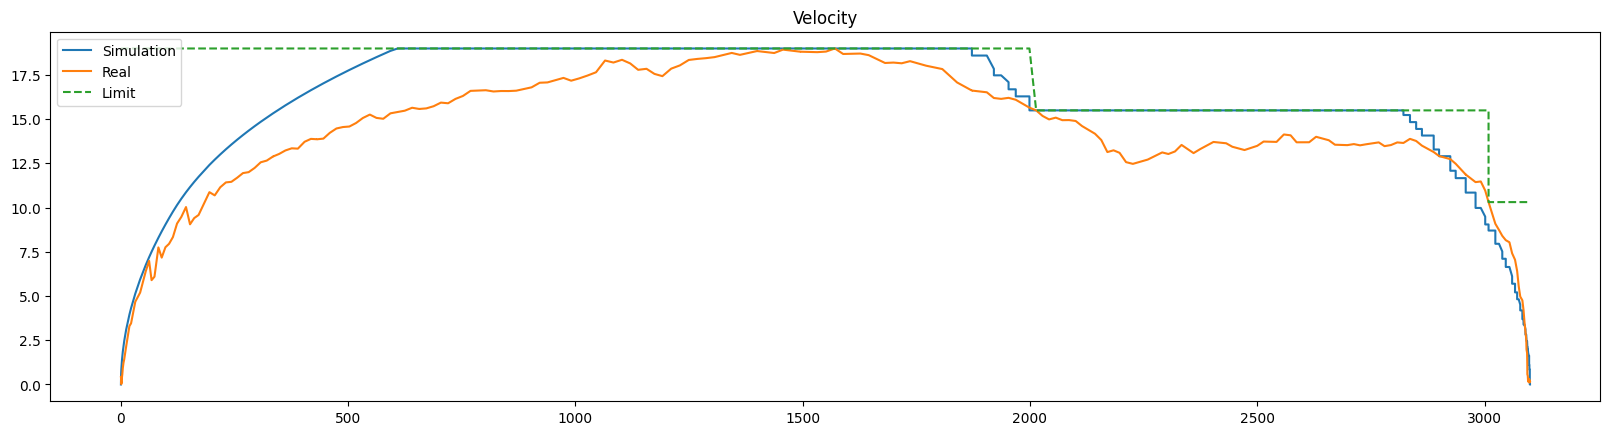

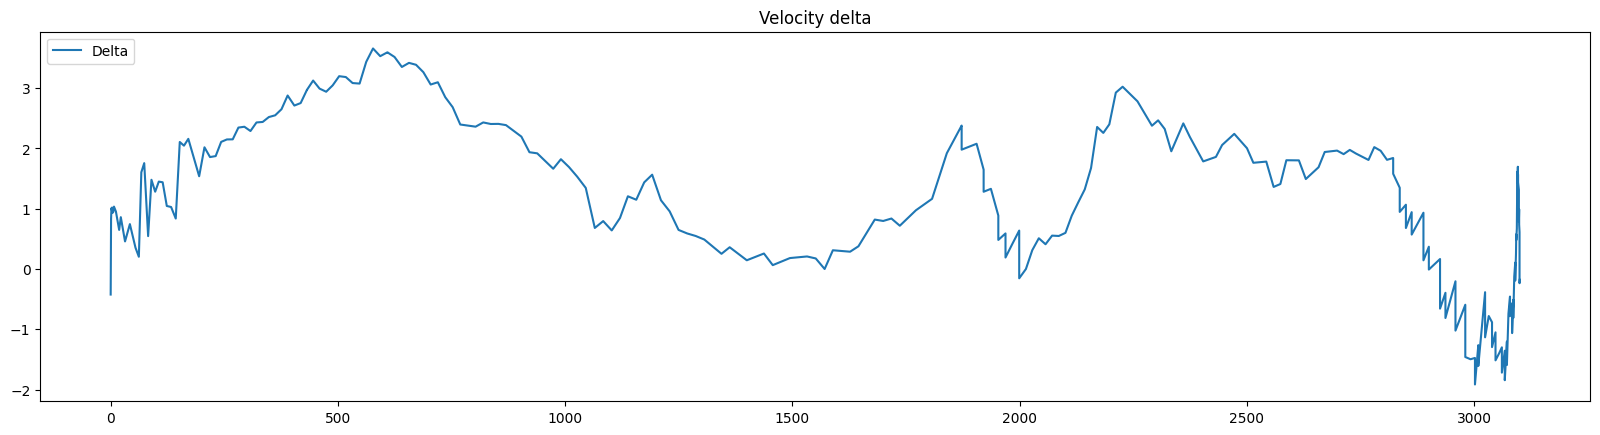

DTW: 130.97233723528032


Map(center=[50.09158134460449, 17.697911262512207], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [10]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 90.213, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Krnov ➡️ Milotice n.Opavou

unique velocities in km/h {32.51300125122071, 65.64228744506836, 66.39419174194336, 69.95200424194336, 69.14400100708008, 60.08073348999024, 62.97499923706055, 63.05600280761719}


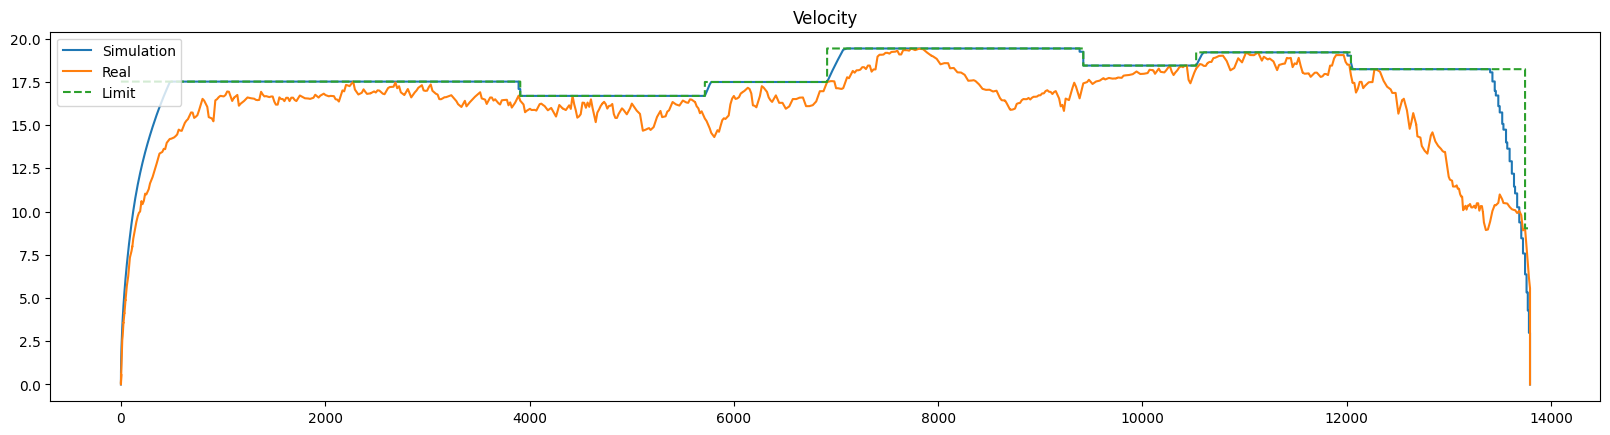

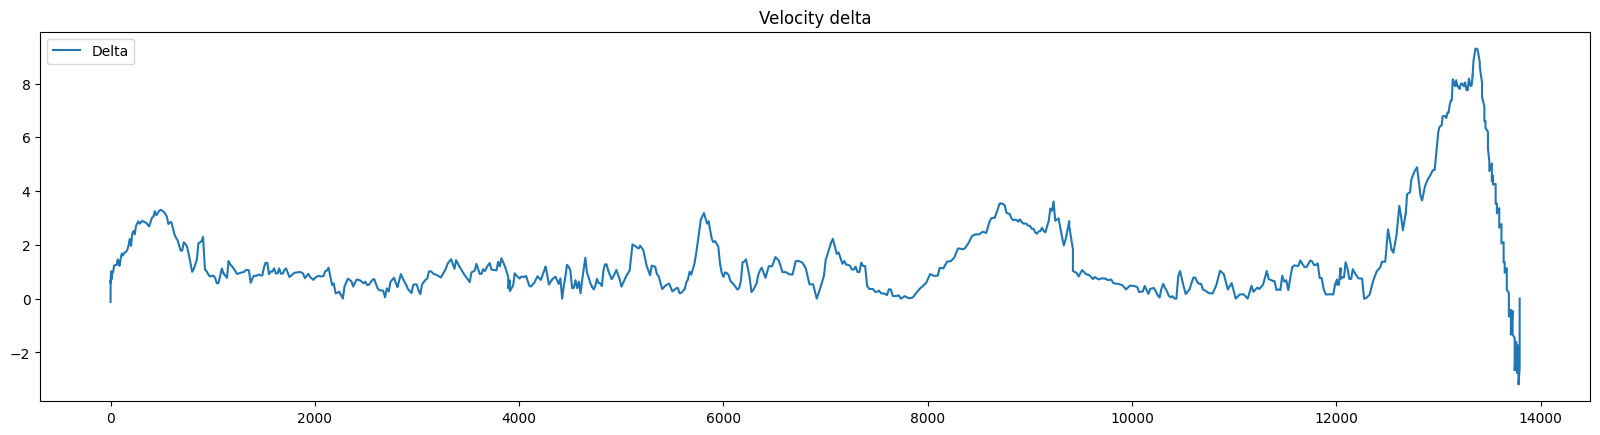

DTW: 1324.0352418746536


Map(center=[50.0518741607666, 17.620561599731445], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [11]:
df_slice = df.loc[5570:7770] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 87.056, "../testing-data/velocity-data/310-pj.json")
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-milotice.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

unique velocities in km/h {40.739000701904295, 67.84600067138673, 71.14900588989258}


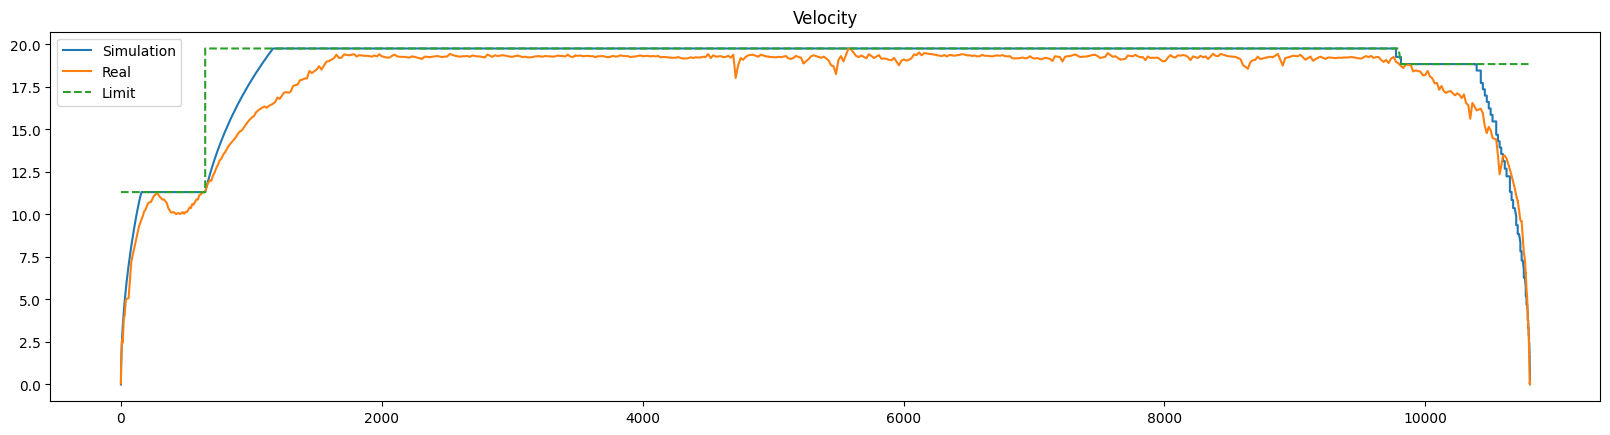

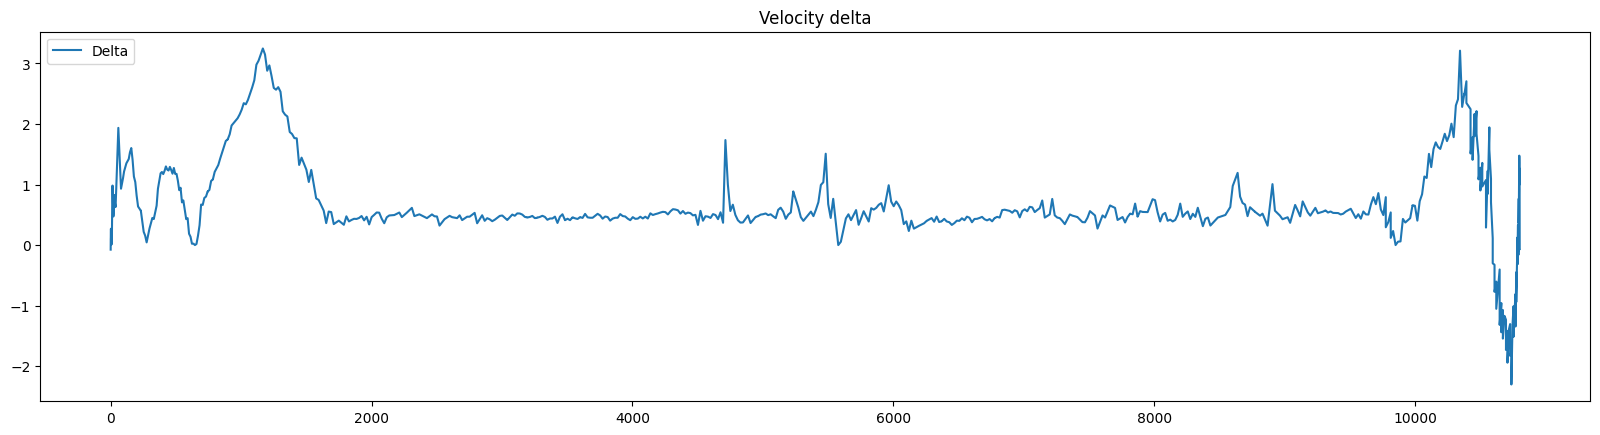

DTW: 557.5809262780336


Map(center=[49.602705001831055, 17.336840629577637], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [12]:
df_slice = df2.loc[1120:2600] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 0.440, "../testing-data/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_09-04-10_olomouc-hlubocky.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

unique velocities in km/h {67.34300537109374, 69.97781524658204, 72.30299606323244, 44.46900329589844, 45.716003036499025, 46.98099975585938, 46.72899742126465, 51.48299789428711, 52.17899894714356, 53.94400405883789, 59.697365570068364}


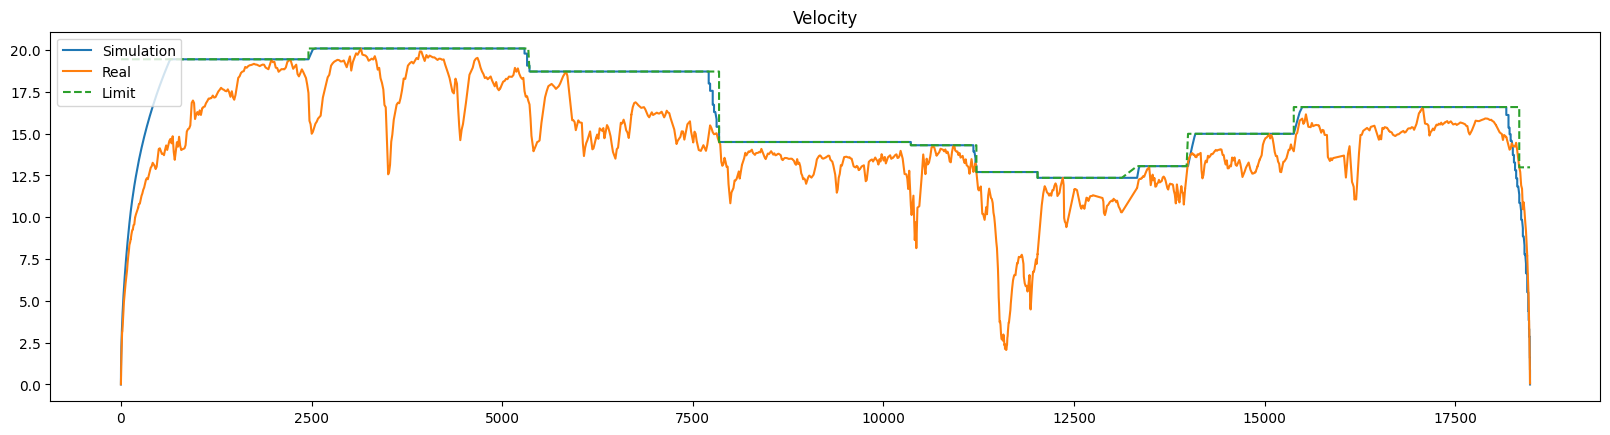

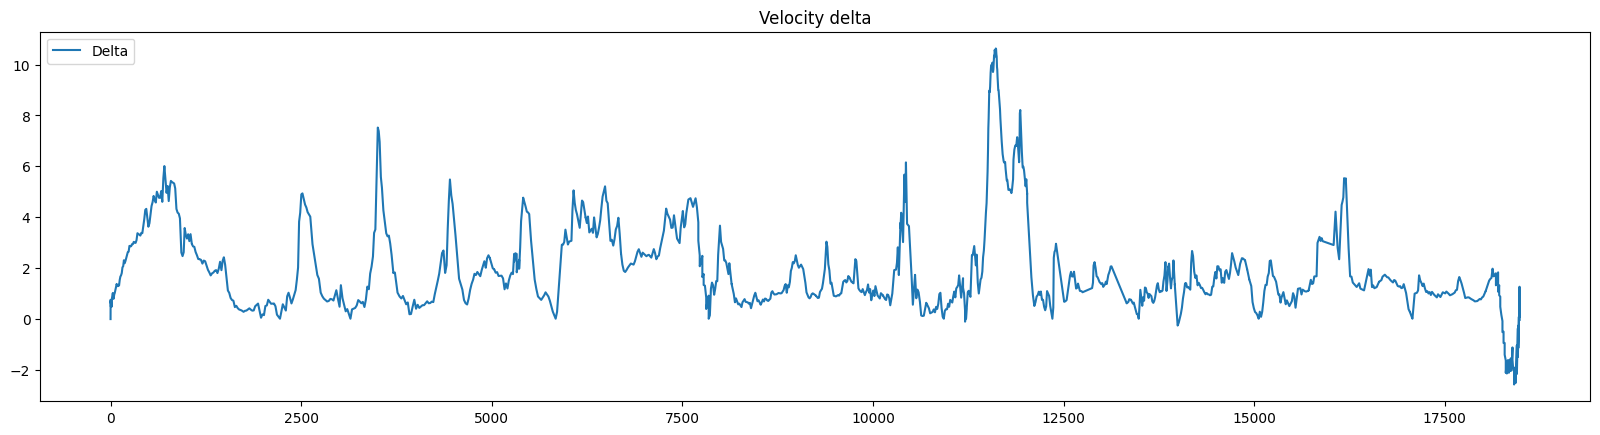

DTW: 3899.3150369360224


Map(center=[49.67659950256348, 17.419564247131348], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [57]:
df_slice = df2.loc[2670:5730] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 10.846, "../testing-data/velocity-data/310-pj.json", True)
infer_velocity(df_slice, 10)

output_geojson = "../testing-data/um7/um7capture_2023-09-29_09-04-10_hlubocky-domasov.geojson"
if PREP_GEOJSONS:
    prep({
        # "input": "NOT NEEDED",
        "output": output_geojson,
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
        "dbtable": "train_testing_data"
    }, df=df_slice)

importlib.reload(tconsumption)

processed_sections.append({"df": df_slice, "geojson": output_geojson})
compare_data(
    df_slice,
    output_geojson
)

#### Milotice n.Opavou ➡️ Bruntál (☠️ noisy data)

In [14]:
# df_slice = df.loc[8335:9787] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 73.260, "../testing-data/velocity-data/310-pj.json")

In [15]:
# output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_milotice-bruntal.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [16]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson
# )

#### Bruntál ➡️ Valšov (☠️ noisy data)

In [17]:
# df_slice = df.loc[10100:10300] # Rozsah bodů mezi stanicemi
# map_velocity(df_slice, 56.370, "../testing-data/velocity-data/310-pj.json")

In [18]:
# output_geojson = "../testing-data/um7/um7capture_2023-09-29_06-26-06_bruntal-valsov.geojson"
# if PREP_GEOJSONS:
#     prep({
#         # "input": "NOT NEEDED",
#         "output": output_geojson,
#         "host": "localhost",
#         "dbname": "railway_mapdb",
#         "dbuser": "postgres",
#         "dbpass": "mysecretpassword",
#         "dbtable": "train_testing_data"
#     }, df=df_slice)

In [19]:
# importlib.reload(tconsumption)

# processed_sections.append({"df": df_slice, "geojson": output_geojson})
# compare_data(
#     df_slice,
#     output_geojson
# )

### 📱 Data z telefonu

In [20]:
# Find two stations (ramp up and ramp down)
df_phone_loc = pd.read_csv("../testing-data/seidl-telefon/Location.csv", delimiter=",")[220:860]
df_phone_loc.reset_index(inplace=True, drop=True)
start_time = df_phone_loc["time"].iloc[0]
stop_time = df_phone_loc["time"].iloc[-1]

# Find acceleration in the same timeframe
# (sampling rate different - that's is why like this)
df_phone_acc = pd.read_csv("../testing-data/seidl-telefon/Accelerometer.csv", delimiter=",")
df_phone_acc = df_phone_acc[(df_phone_acc["time"] >= start_time) & (df_phone_acc["time"] <= stop_time)]
df_phone_acc.reset_index(inplace=True, drop=True)
df_phone_acc

,time,seconds_elapsed,z,y,x
0,1695978715934436000,202.310436,-0.022504,0.057136,0.004057
1,1695978715953393400,202.329393,0.001695,0.057180,0.008538
2,1695978715972351000,202.348351,0.003605,0.048180,-0.007852
3,1695978715991308300,202.367308,0.022114,0.032709,0.027355
4,1695978716010265900,202.386266,-0.015833,0.031453,-0.031993
...,...,...,...,...,...
33626,1695979352841621000,839.217621,0.028306,0.154919,0.006014
33627,1695979352860578300,839.236578,0.001878,0.145120,0.012852
33628,1695979352879535600,839.255536,0.018169,0.189503,-0.011000
33629,1695979352898493000,839.274493,0.015572,0.218727,-0.005773


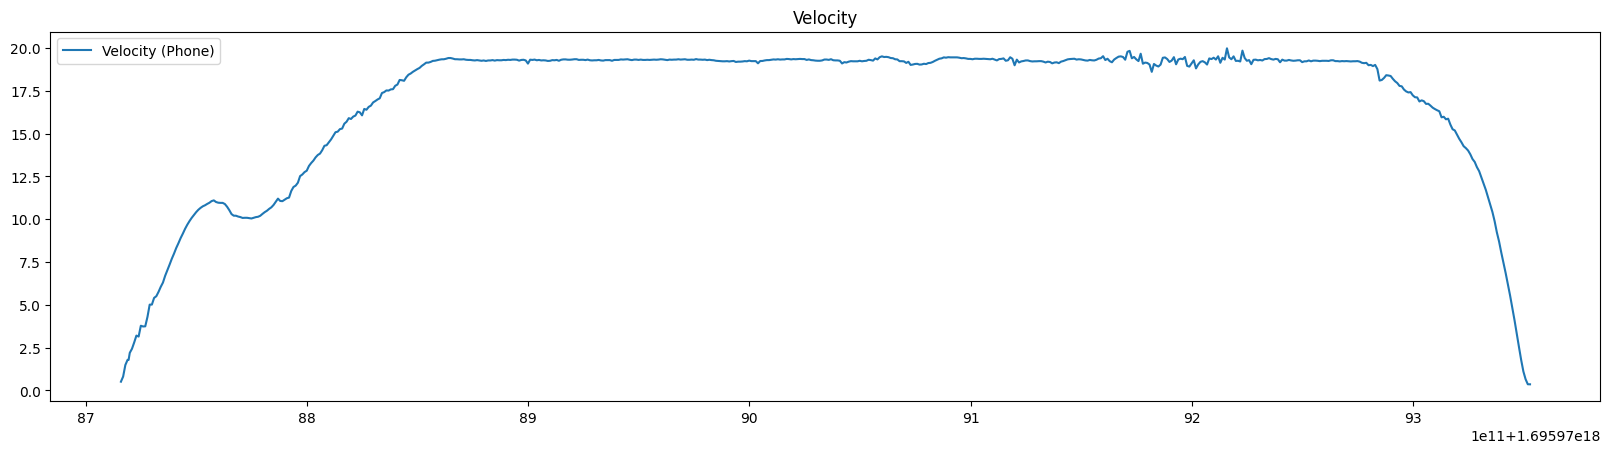

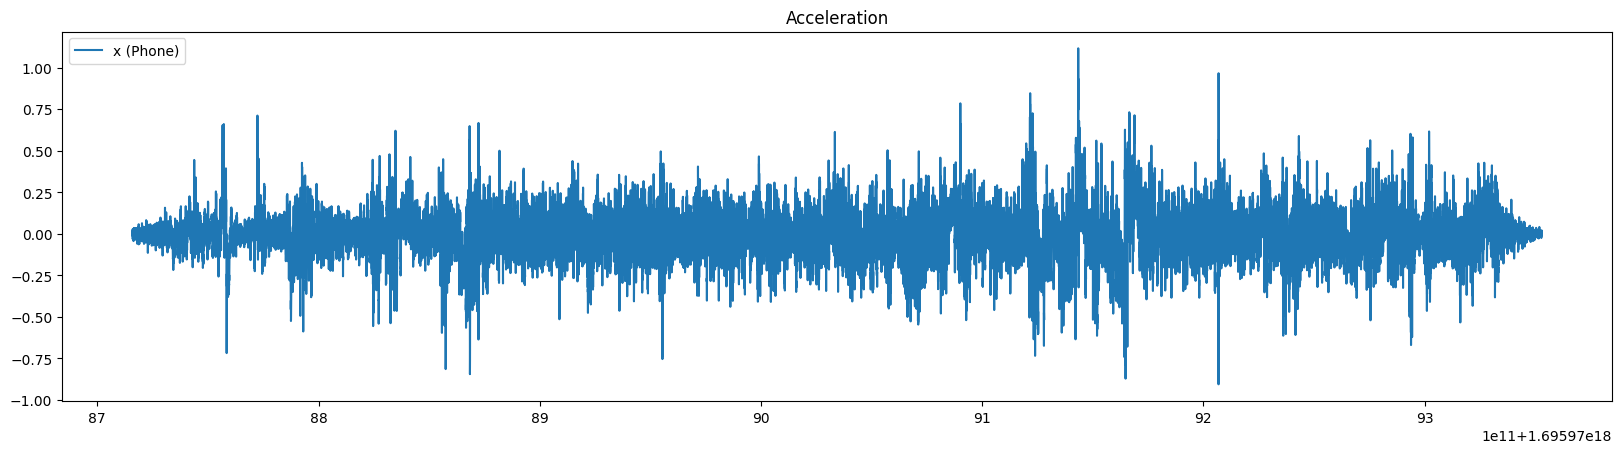

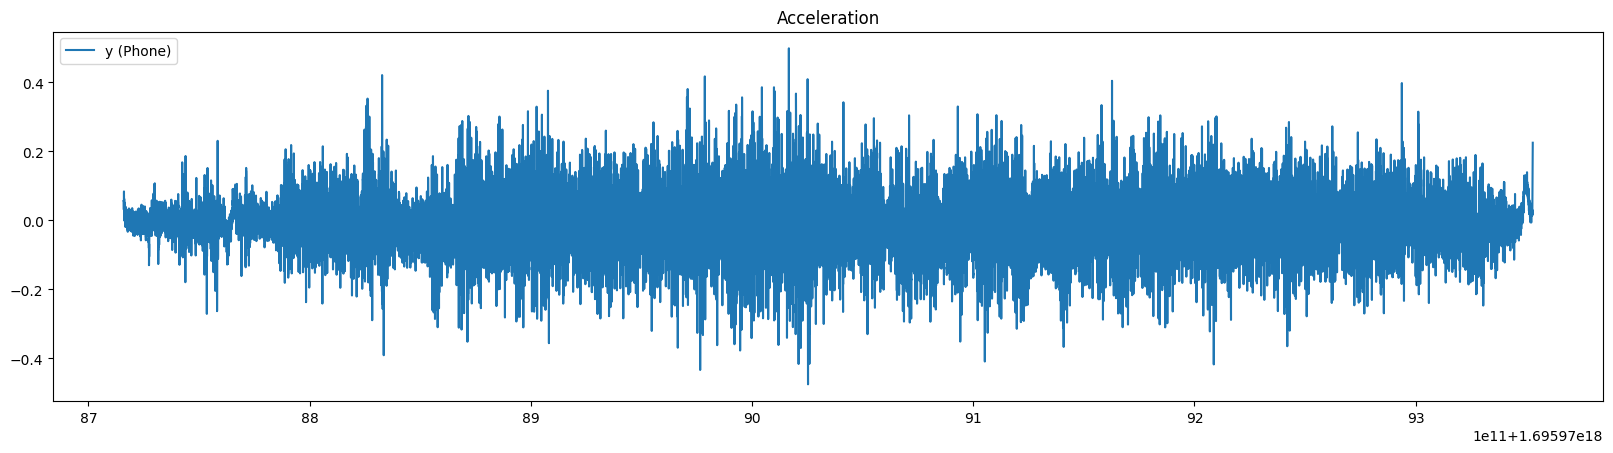

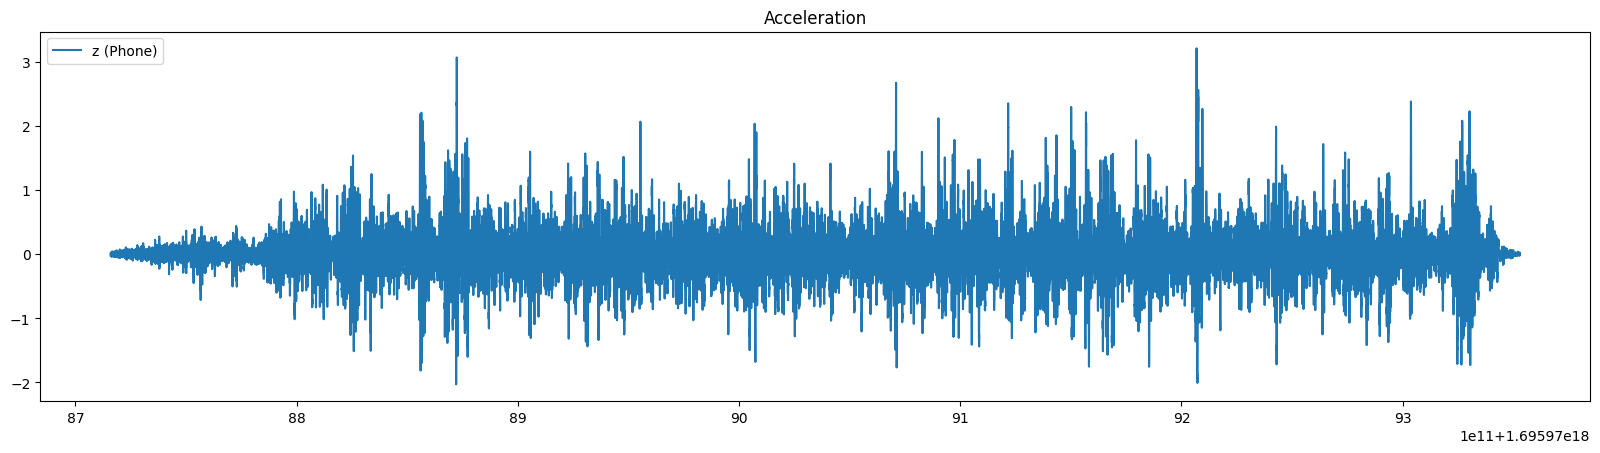

In [21]:
render_plot(
    "Velocity",
    df_phone_loc["time"],
    [df_phone_loc["speed"]],
    ["Velocity (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["x"]],
    ["x (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["y"]],
    ["y (Phone)"]
)

render_plot(
    "Acceleration",
    df_phone_acc["time"],
    [df_phone_acc["z"]],
    ["z (Phone)"]
)

### 🇳🇴 Porovnání s norskou simulací

In [22]:
def map_velocity_2sim(points, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    dist_values = [0]
    for i,p in enumerate(points):
        if i+1 >= len(points):
            continue
        dist = tconsumption.calc_distance_two_points(p, points[i+1])
        dist_values.append(dist+dist_values[-1])

    max_velocities = []

    for d in dist_values:
        for tv in track_velocity[::-1]:
            start_in_m = tv["start"]*1000
            if first_offset*1000 - d < start_in_m:
                max_velocities.append(tv["value"])
                break

    return [x/3.6 for x in max_velocities]

def compare_data_2sim(df_sim, geojson_path: str, first_dist_offset, velocity_fp):
    # Calculated data
    c = tconsumption.Consumption()
    c.load_from_file(geojson_path)
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 999,
        "Curve B": 100,
        "Running a": 2,
        "Running b": 0.054,
        "Running c": 0.00034,
        "Recuperation coefficient": 0.70,
        "Comfortable acceleration": 0.98
    }
    c.max_velocities_in_mps = map_velocity_2sim(c.points, first_dist_offset, velocity_fp)

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 0

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
    render_plot(
        "Energy",
        c.series["dist_values"],
        [energy_calculated],
        ["JN simulation", "Norwegian simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Norwegian energy",
        df_sim["distance"],
        [df_sim["Battery"]],
        ["Battery"],
        ["solid"]
    )

    # render_plot(
    #     "Norwegian energy",
    #     df_sim["distance"],
    #     [df_sim["Battery"], df_sim["Hydrogen"], df_sim["Diesel"], df_sim["OLE"]],
    #     ["Battery", "Hydrogen", "Diesel", "OLE"],
    #     ["solid"]*4
    # )

    render_plot(
        "Exerted force",
        c.series["dist_values"],
        [c.series["exerted_force_values"]],
        ["JN simulation"],
        ["solid", "solid"]
    )

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], c.max_velocities_in_mps+[c.max_velocities_in_mps[-1]]],
        ["JN simulation", "Max velocity"],
        ["solid", "dashed"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["JN simulation"],
        ["solid"]
    )

    print(f"JN simulation final energy: {energy_calculated[-1]}")
    print(f"Norwegian simulation final energy: {df_sim['Battery'].iloc[-1]}")

    dtw = fastdtw(energy_calculated, df_sim["Battery"])[0]
    print("DTW:", dtw)

In [23]:
if PREP_GEOJSONS:
    get_rail({
        "output": "../testing-data/norway-sim/opava-olomouc.geojson",
        "host": "localhost",
        "dbname": "railway_mapdb",
        "dbuser": "postgres",
        "dbpass": "mysecretpassword",
    }, 49002, True)

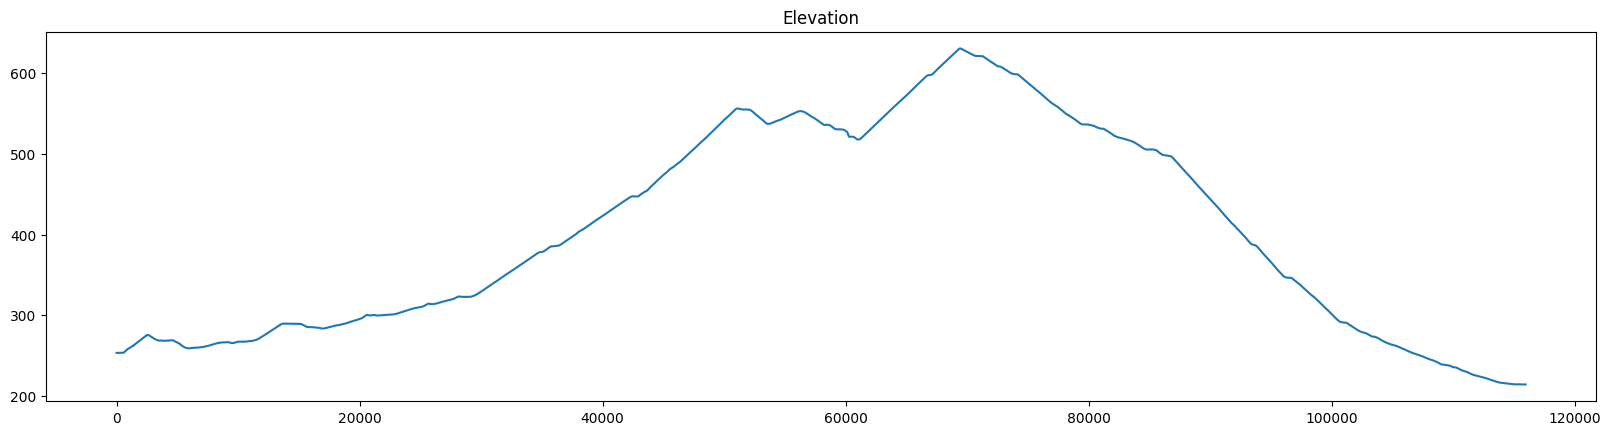

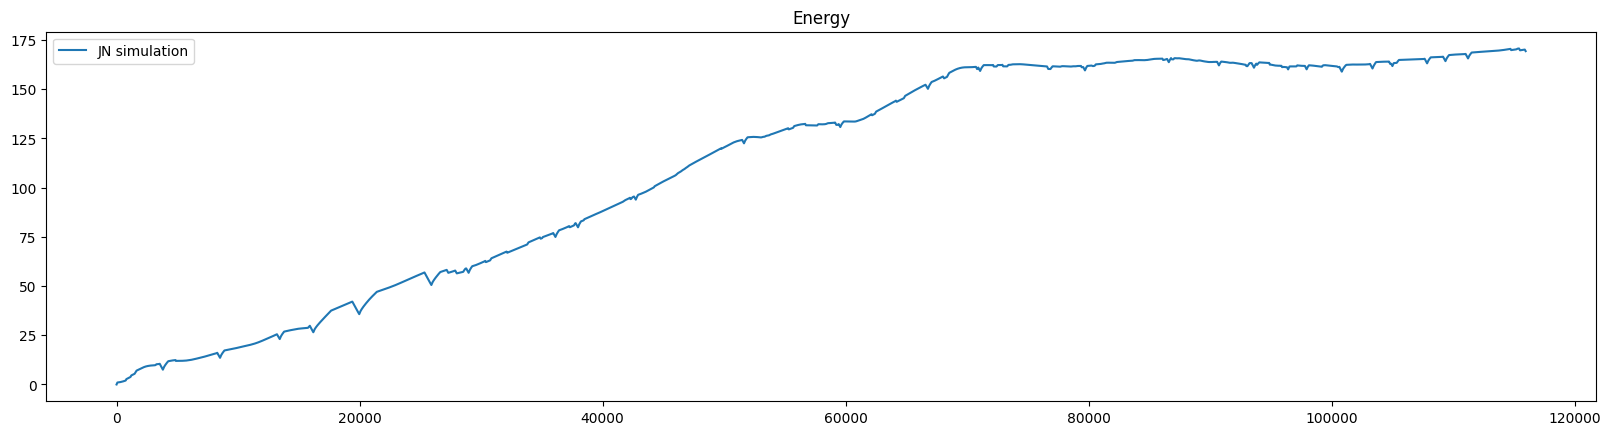

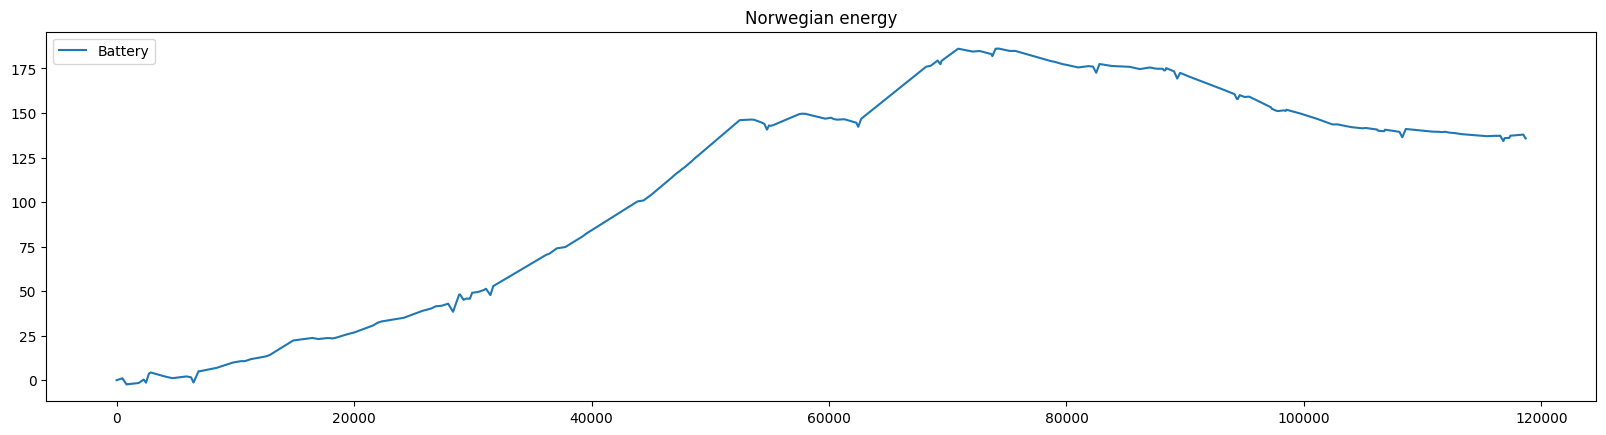

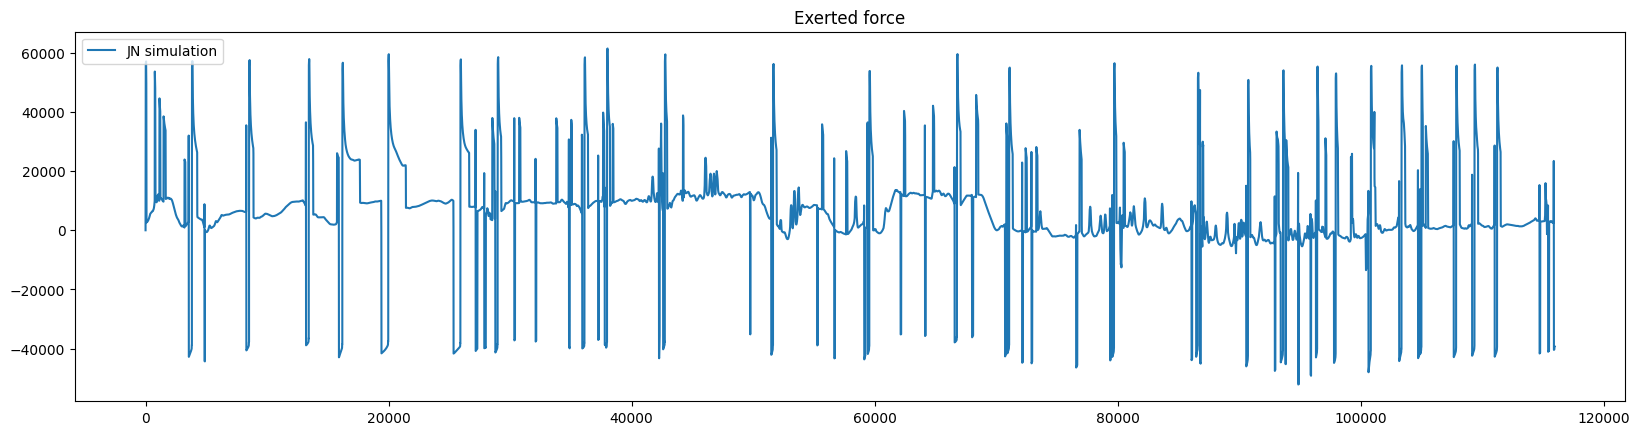

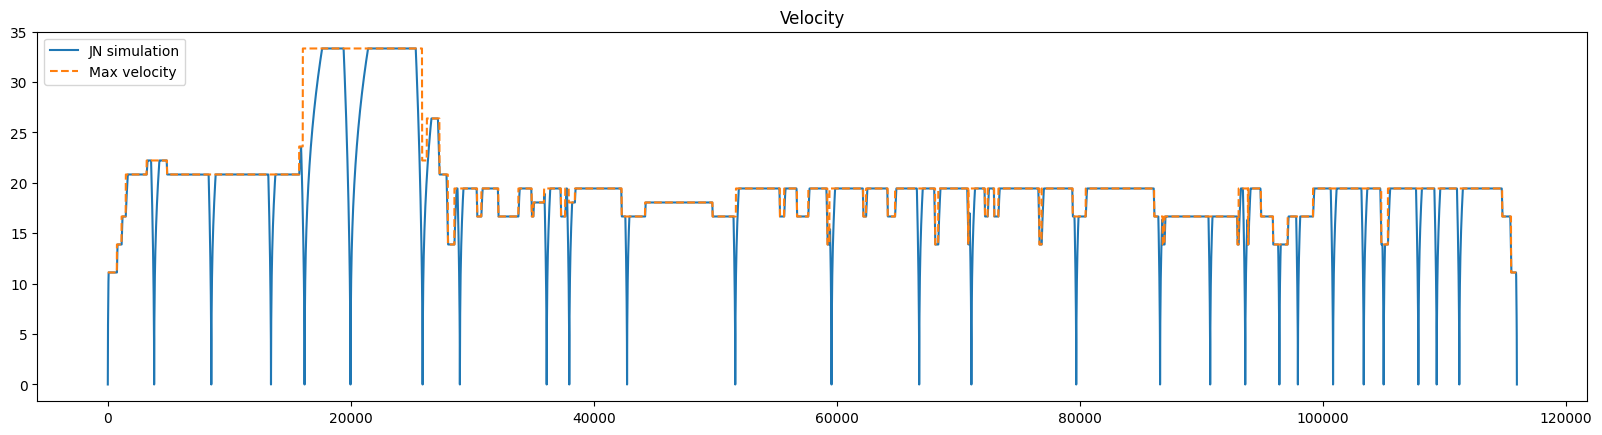

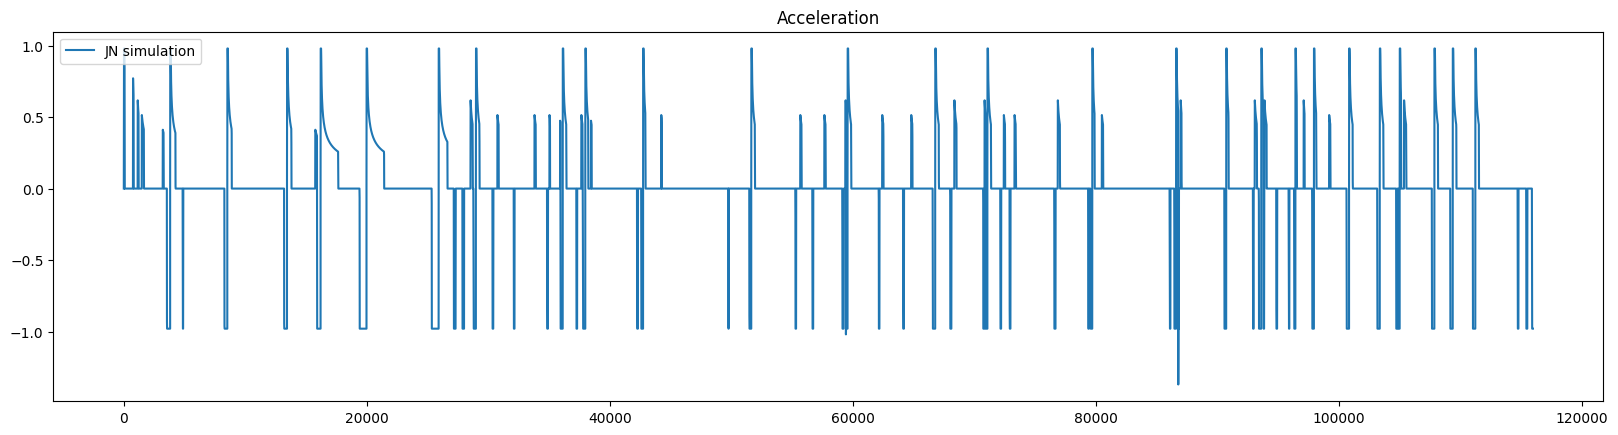

JN simulation final energy: 169.37162912867228
Norwegian simulation final energy: 135.61772263885865
DTW: 86344.02898256936


In [24]:
# Read and process
df_norway = pd.read_csv("../testing-data/norway-sim/West_energy.csv", delimiter=",", header=[0,1])
df_norway.columns = [x[0] for x in df_norway.columns]
df_norway = df_norway.rename(columns={"Unnamed: 0_level_0": "distance"})

# Remove first few stations (Ostrava-Opava)
df_norway = df_norway[df_norway["distance"] >= 36000]
df_norway.reset_index(inplace=True, drop=True)

# Reset variables
for k in df_norway.keys():
    offset_value = df_norway[k].iloc[0]
    df_norway[k] = df_norway[k] - offset_value

compare_data_2sim(
    df_norway,
    "../testing-data/norway-sim/opava-olomouc.geojson",
    116.193, "../testing-data/velocity-data/310.json"
)

### 🚧 Ladění algoritmu

[0, 410, 849, 1398, 1688, 2030, 2597, 2935, 3713, 3903, 4398, 5363, 6100, 6730, 7120, 7968, 8656, 9047, 9337, 9602, 9772, 10045, 10261, 10414, 10726, 10907, 11123, 11641]


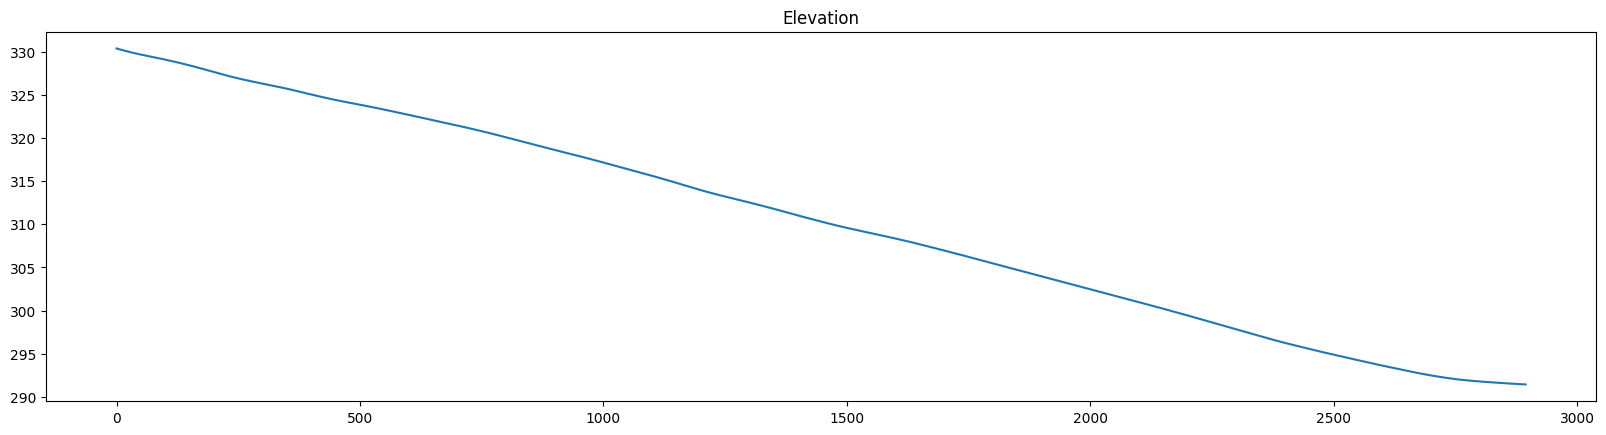

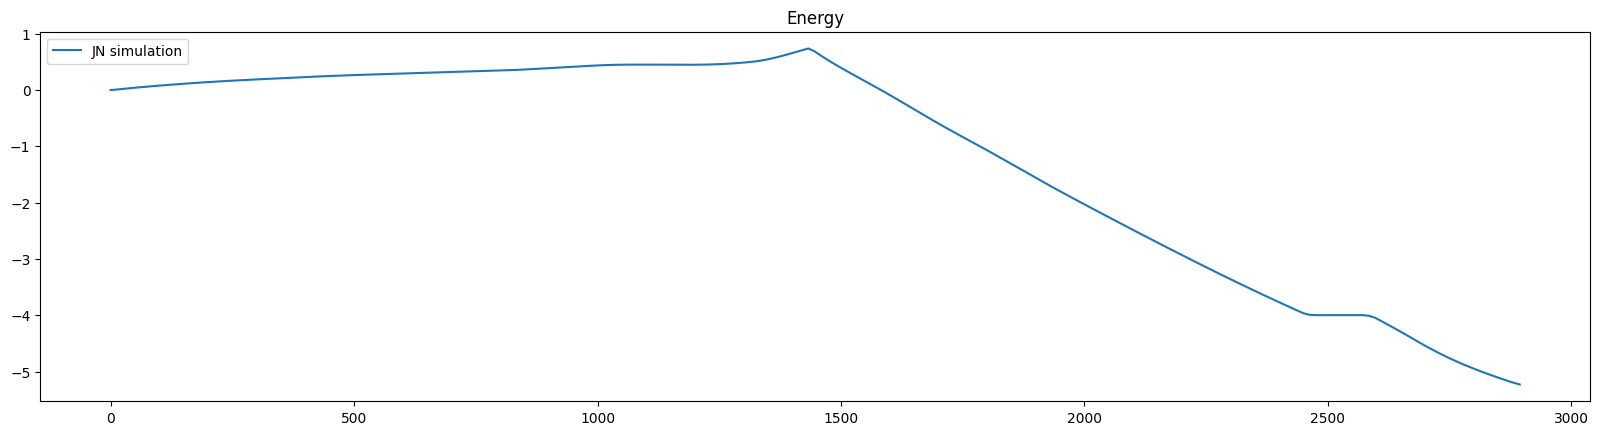

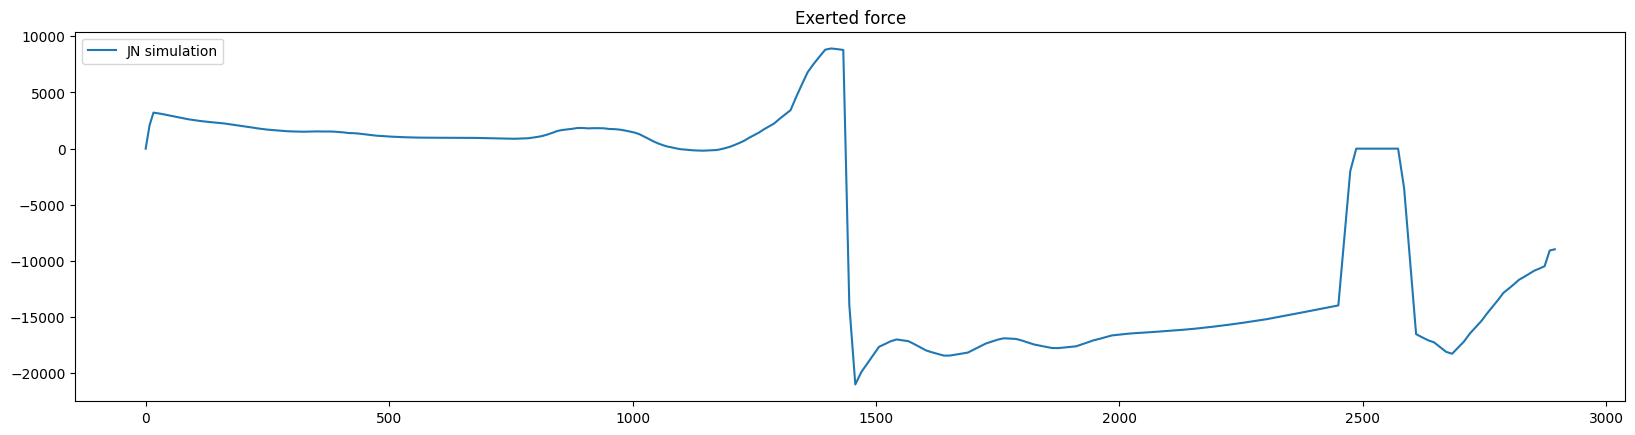

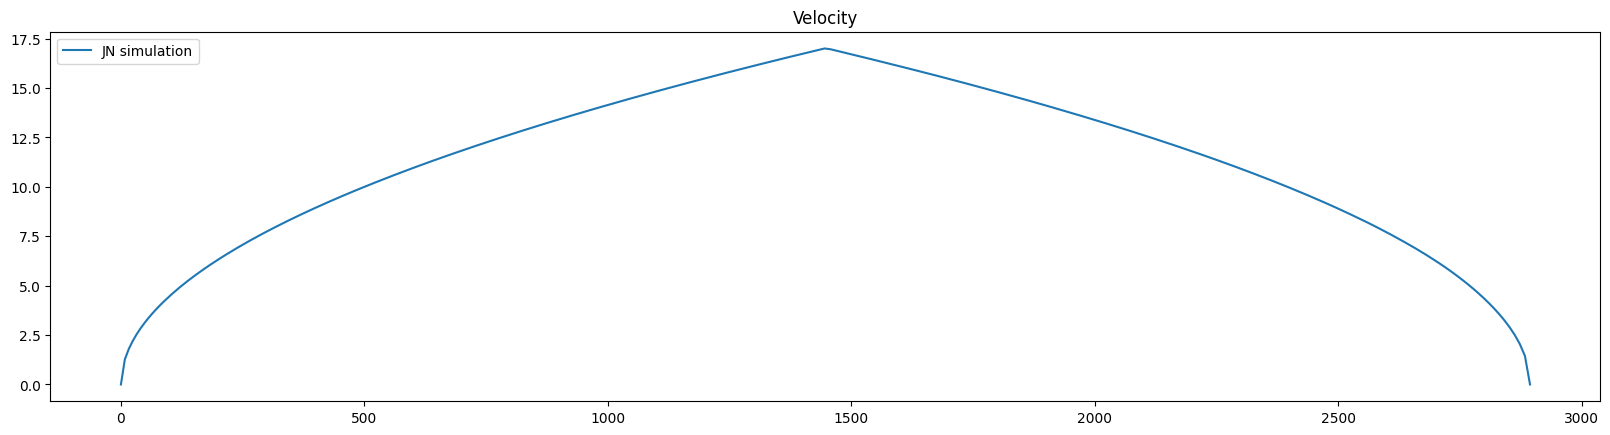

JN simulation final energy: -5.228312799488363


In [25]:
importlib.reload(tconsumption)

# Calculated data
c = tconsumption.Consumption()
c.variable_params = {
    "Elevation smoothing": 100,
    "Curve smoothing": 10,
    "Curve A": 999,
    "Curve B": 100,
    "Running a": 2,
    "Running b": 0.054,
    "Running c": 0.00034,
    "Recuperation coefficient": 1,
    "Comfortable acceleration": 0.1
}
c.load_from_file("../testing-data/norway-sim/opava-olomouc.geojson")
# c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"]) # TODO: Add limits

# Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
c.params["power_limit"] = 480*1000
c.params["mass_locomotive"] = 56000
c.params["mass_wagon"] = 0

# Picking a slice
print(c.stations)
from_station = 20
to_station = 21

start_idx = c.stations[from_station]
end_idx = c.stations[to_station]

c.points = c.points[start_idx:end_idx]
c.stations = c.stations[from_station:to_station+1]
c.stations = [x-c.stations[0] for x in c.stations]
c.max_velocities_in_mps = c.max_velocities_in_mps[start_idx:end_idx]
c.series["elevation_values"] = c.series["elevation_values"][start_idx:end_idx]

# Running the simulation
c.run()

# Plotting
render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

energy_calculated = [x/3600000 for x in c.series["energy_from_exerted_force"]]
render_plot(
    "Energy",
    c.series["dist_values"],
    [energy_calculated],
    ["JN simulation"],
    ["solid"]
)
render_plot(
    "Exerted force",
    c.series["dist_values"],
    [c.series["exerted_force_values"]],
    ["JN simulation"],
    ["solid", "solid"]
)

render_plot(
    "Velocity",
    c.series["dist_values"],
    [c.series["velocity_values"]],
    ["JN simulation", "Norwegian simulation"],
    ["solid", "solid"]
)

print(f"JN simulation final energy: {energy_calculated[-1]}")

# dtw = fastdtw(energy_calculated, HERE)[0]
# print("DTW:", dtw)

### 📈 Hledání funkce omezující "kroutící moment"

In [26]:
def draw_init_velocity_delta(df_measured, geojson_path, filter_window, fit_degree, interest_range=None):
    importlib.reload(tconsumption)

    c = run_simulation(df_measured, geojson_path)

    if interest_range is None:
        interest_range = (0, len(c.series["velocity_values"]))

    # Get deltas
    velocity_deltas = []
    for i in range(len(c.series["velocity_values"])):
        delta = c.series["velocity_values"][i] - df_measured["gps_speed"].iloc[i]
        velocity_deltas.append(delta)
        # if interest_range is None and delta <= 0 and i >= 100:
        #     interest_range = (0, i+1)
        # print(delta)
    print(interest_range)
    # interest_range = (0, len(velocity_deltas)) # debug

    interest_dists = c.series["dist_values"][interest_range[0]:interest_range[1]]
    interest_deltas = velocity_deltas[interest_range[0]:interest_range[1]]
    interest_sim_velocity = c.series["velocity_values"][interest_range[0]:interest_range[1]]
    interest_measured_velocity = df_measured["gps_speed"][interest_range[0]:interest_range[1]]
    interest_max_velocity = c.max_velocities_in_mps[interest_range[0]:interest_range[1]]

    # render_plot(
    #     "Velocity delta (full)",
    #     c.series["dist_values"],
    #     [velocity_deltas],
    #     ["Delta (actual)"],
    #     ["solid"],
    #     show_hline=True
    # )

    render_plot(
        "Velocity (full)",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    # Fitting a polynomial
    poly = np.poly1d(np.polyfit(interest_dists, interest_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta (interest)",
        interest_dists,
        [interest_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    render_plot(
        "Velocity (interest)",
        interest_dists,
        [interest_sim_velocity, interest_measured_velocity, interest_max_velocity],
        ["Simulation", "Real", "Limit"],
        ["solid", "solid", "dashed"]
    )

    # Savgol Filter
    filtered_deltas = savgol_filter(interest_deltas, filter_window, 0, mode="nearest")

    # Fitting a polynomial (to Savgol)
    poly = np.poly1d(np.polyfit(interest_dists, filtered_deltas, fit_degree))
    # print("polynomial:", poly)

    render_plot(
        "Velocity delta",
        interest_dists,
        [filtered_deltas, poly(interest_dists)],
        ["Delta (actual)", "Delta (polynomial fit)"],
        ["solid", "dashed"],
        show_hline=True
    )

    return {
        "deltas": interest_deltas,
        "dists": interest_dists,
        "poly": poly
    }

In [48]:
all_poly_graphs = []

#### Opava západ ➡️ Krnov-Cvilín

unique velocities in km/h {80.52800674438477, 107.11000442504883, 100.52200469970704, 84.99800720214844}
(0, 200)


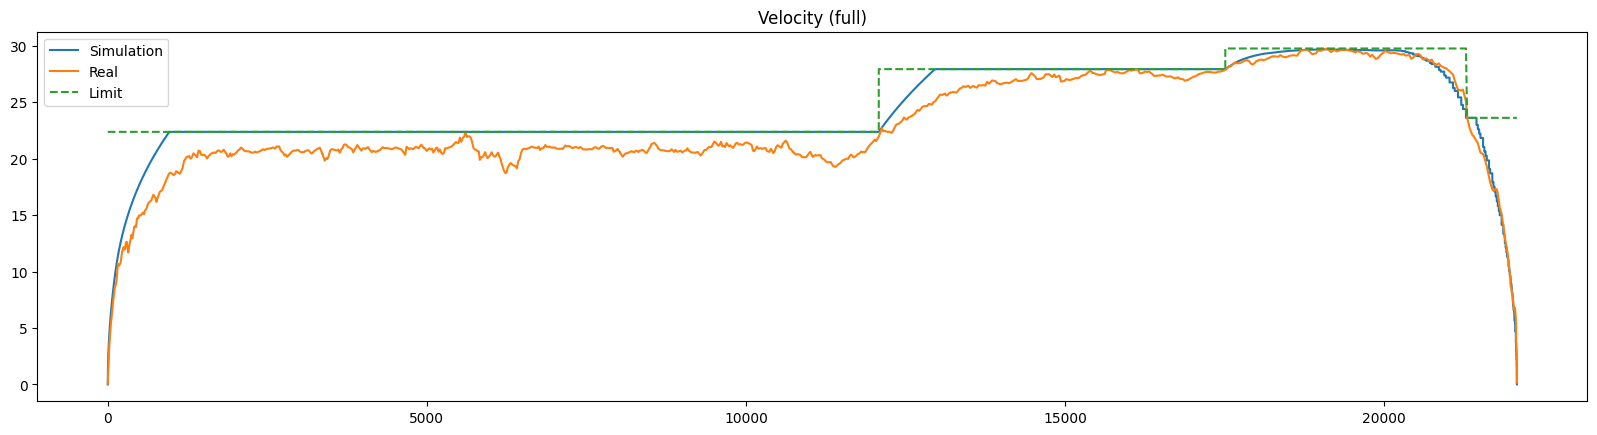

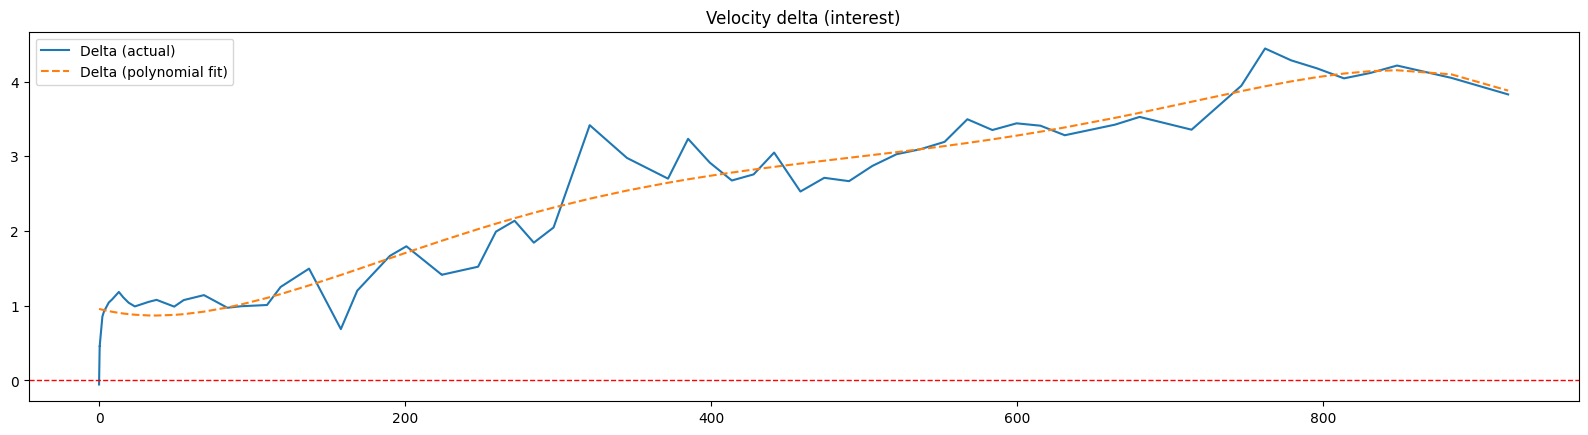

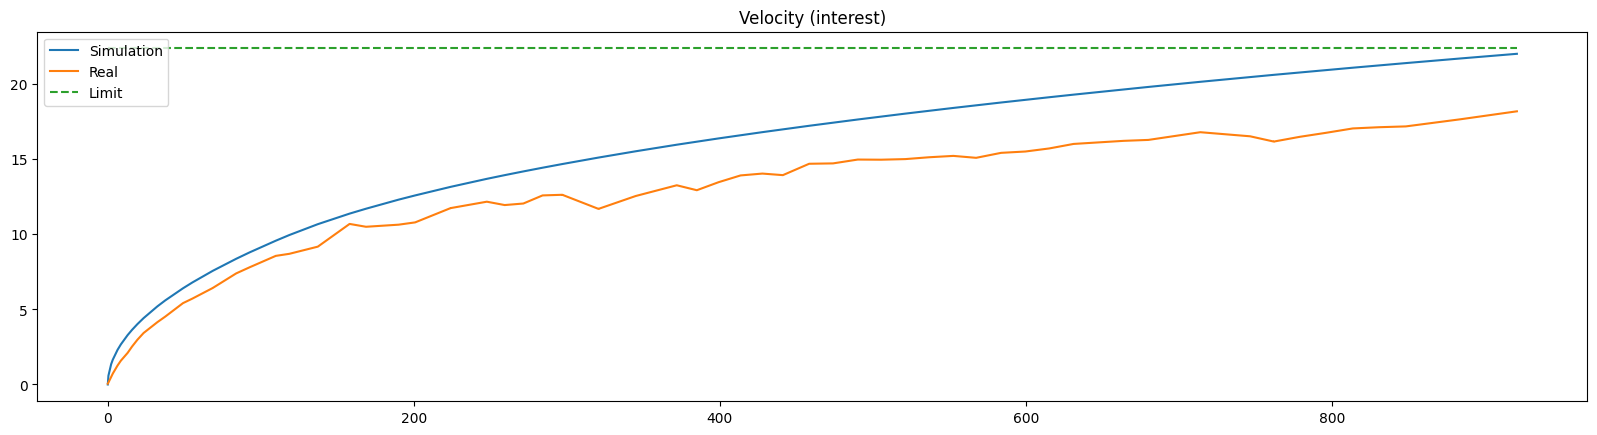

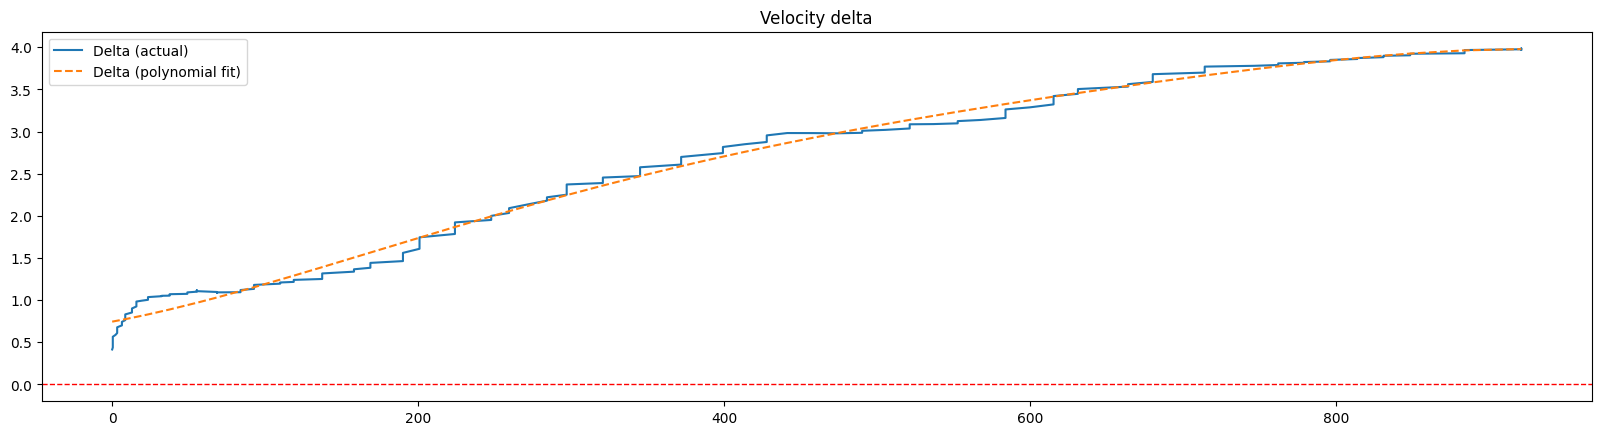

In [49]:
output = draw_init_velocity_delta(
    processed_sections[0]["df"], processed_sections[0]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 200)
)
all_poly_graphs.append(output)

#### Krnov-Cvilín ➡️ Krnov

unique velocities in km/h {68.37500610351562, 37.11300086975098, 55.77700424194337}
(0, 238)


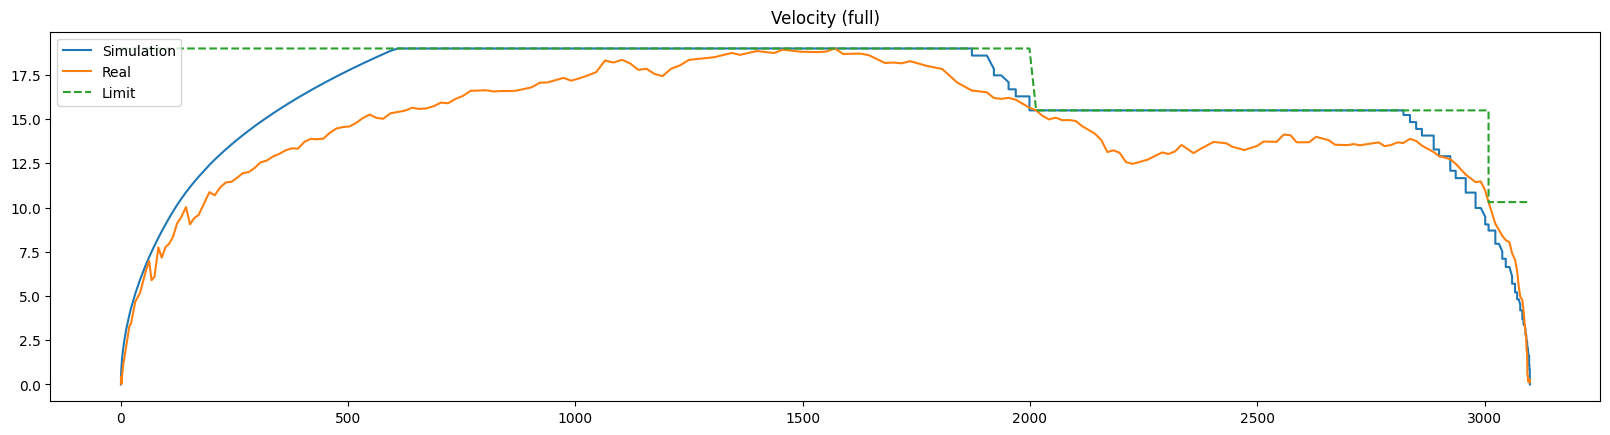

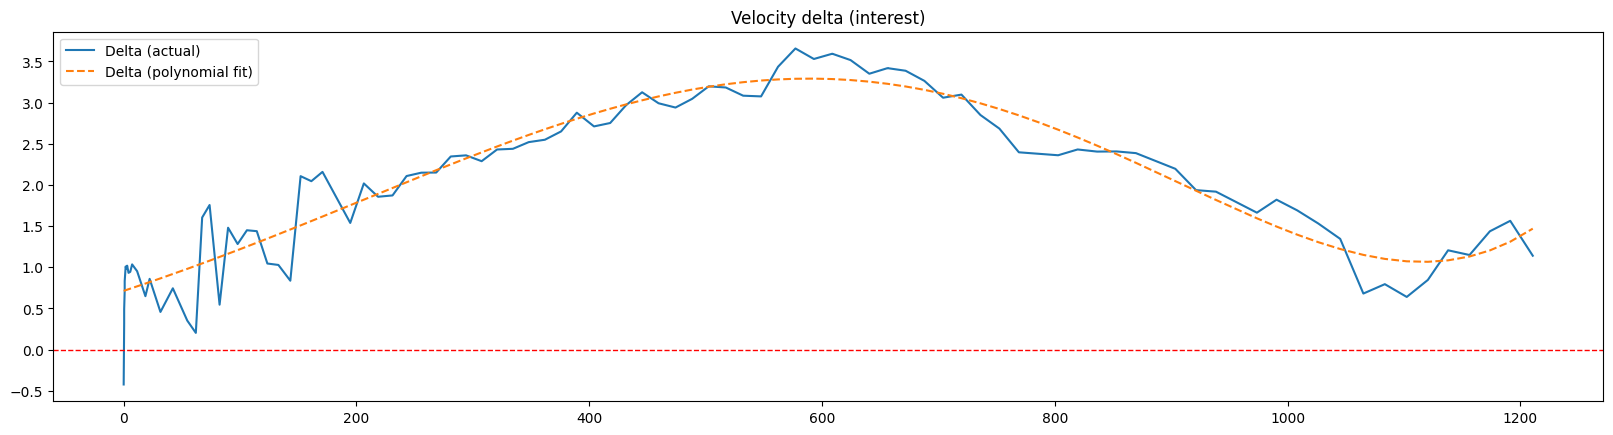

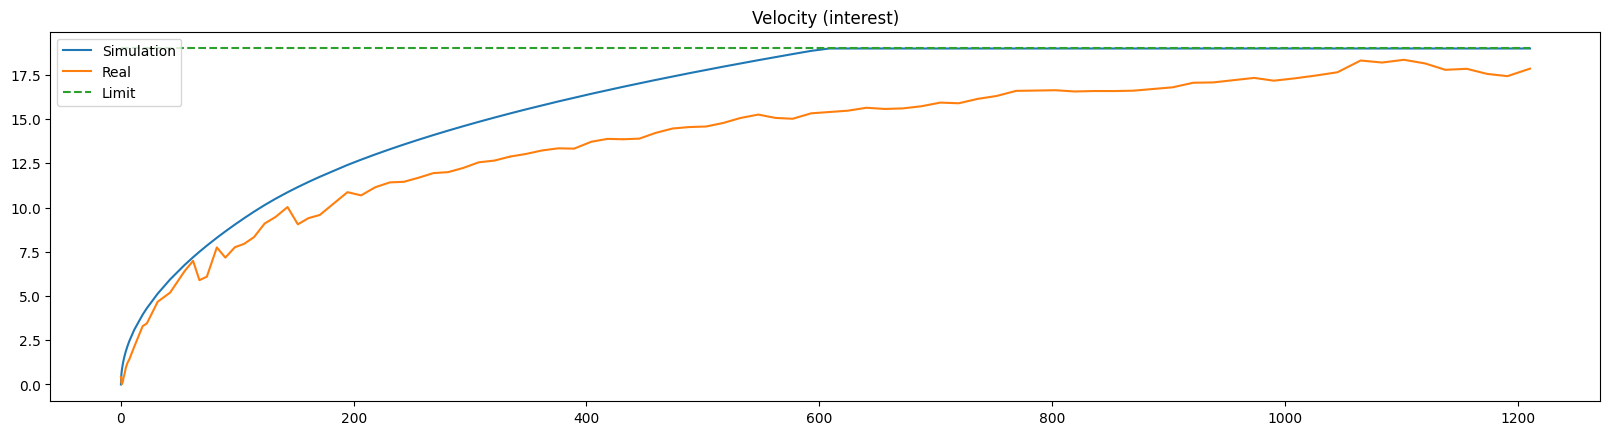

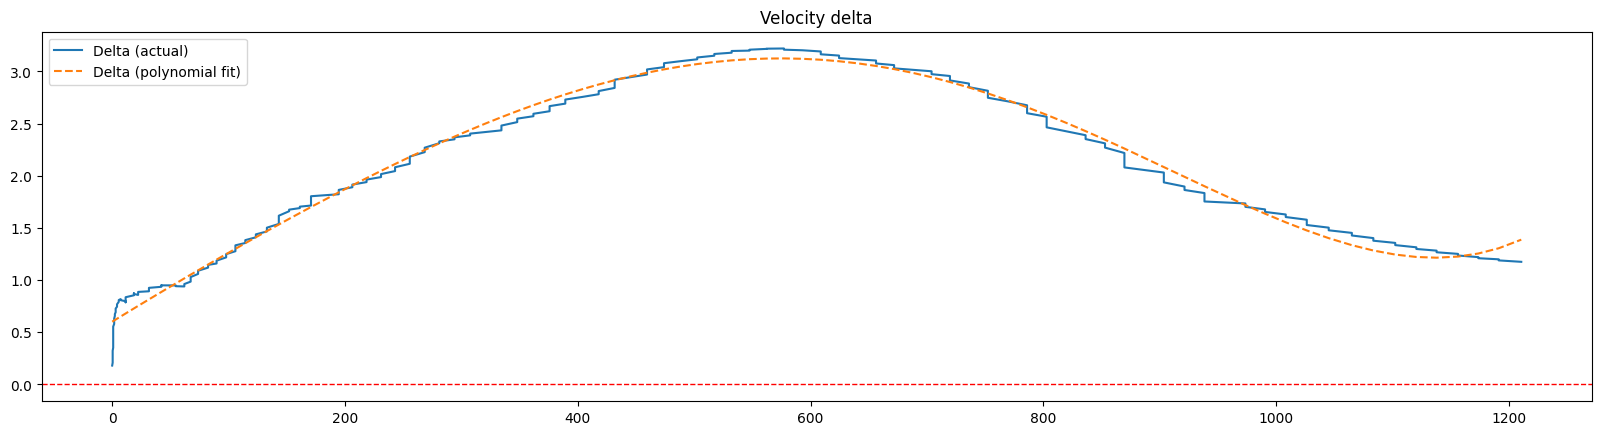

In [50]:
output = draw_init_velocity_delta(
    processed_sections[1]["df"], processed_sections[1]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 238)
)
all_poly_graphs.append(output)

#### Krnov ➡️ Milotice n. Opavou

unique velocities in km/h {32.51300125122071, 65.64228744506836, 66.39419174194336, 69.95200424194336, 69.14400100708008, 60.08073348999024, 62.97499923706055, 63.05600280761719}
(0, 255)


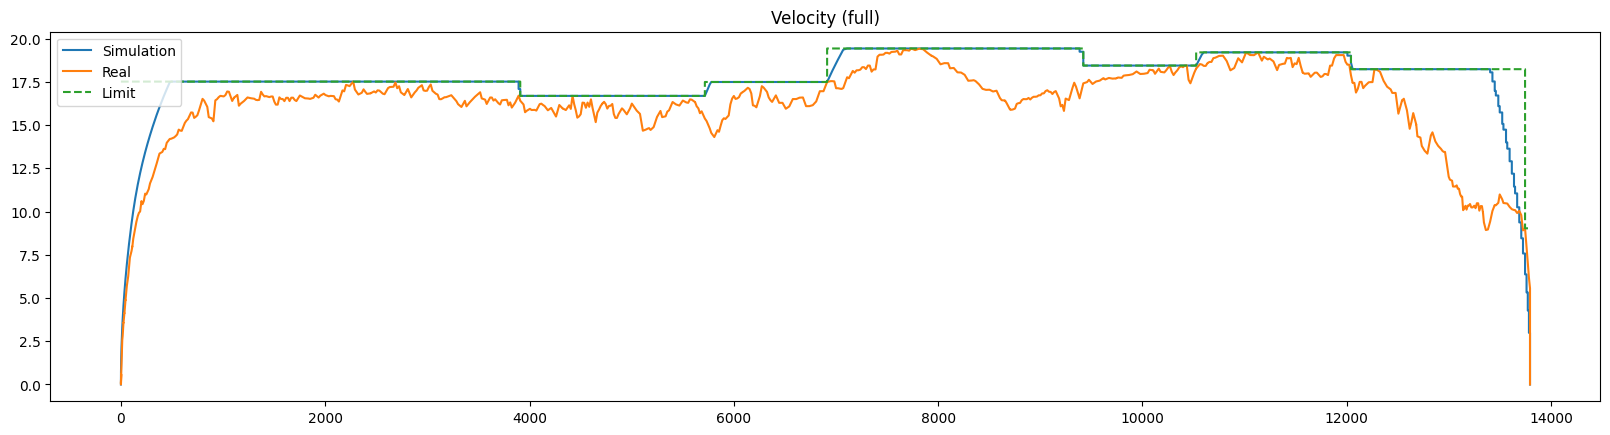

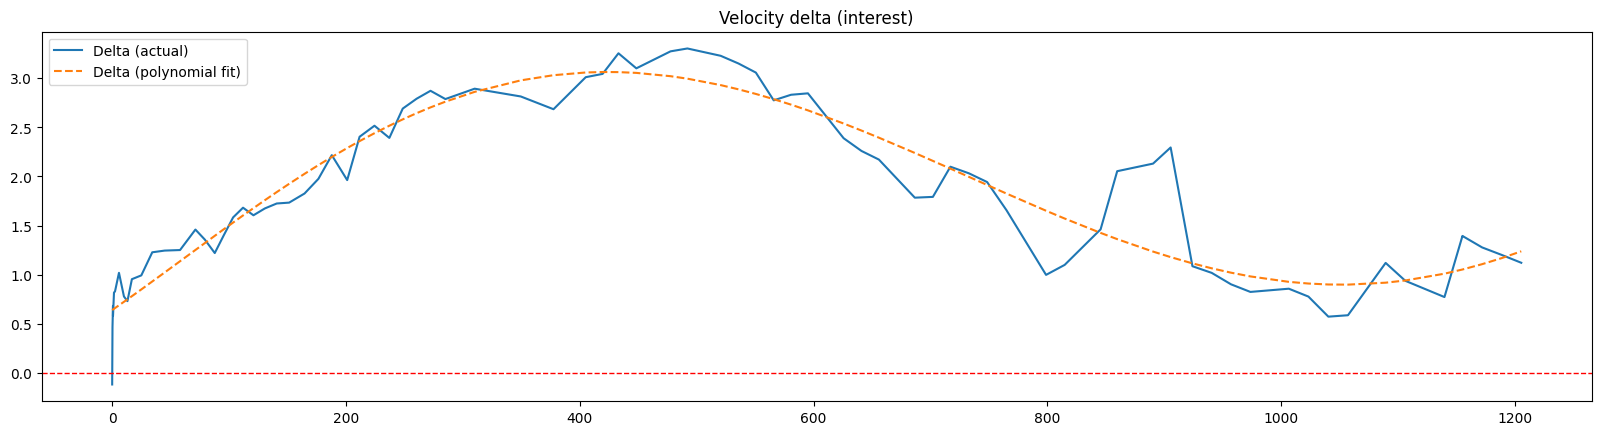

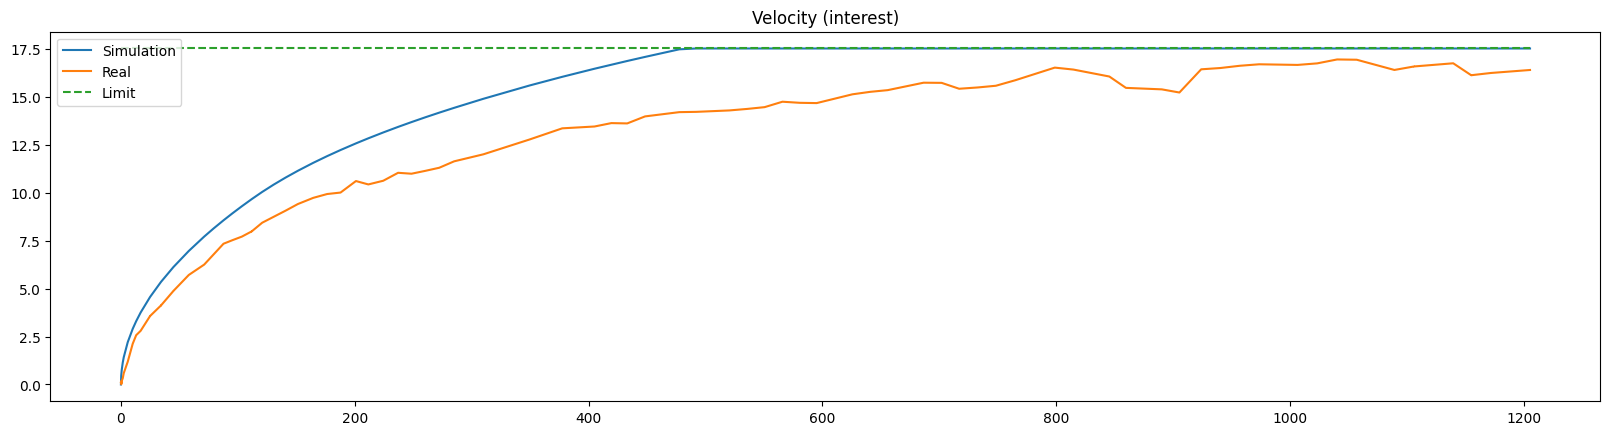

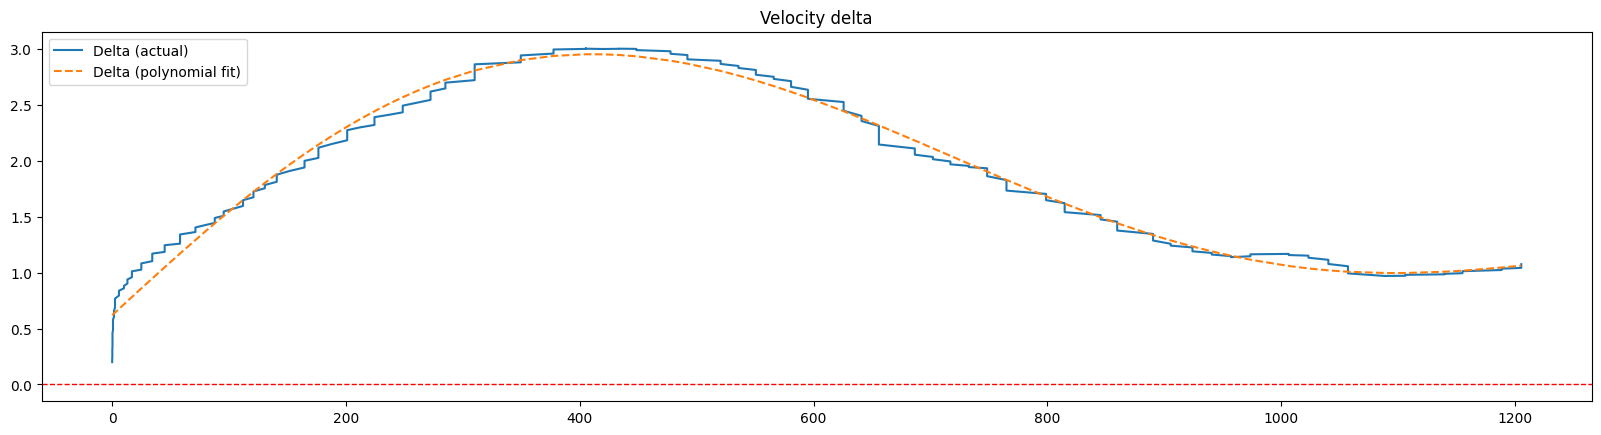

In [51]:
output = draw_init_velocity_delta(
    processed_sections[2]["df"], processed_sections[2]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 255)
)
all_poly_graphs.append(output)

#### Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí

unique velocities in km/h {40.739000701904295, 67.84600067138673, 71.14900588989258}
(0, 105)


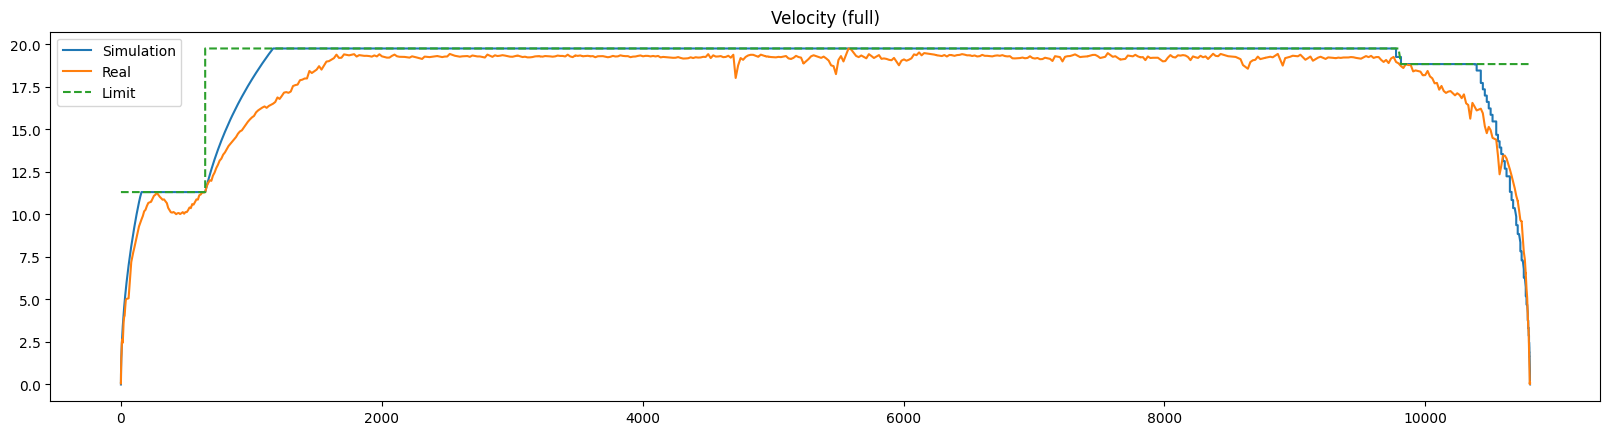

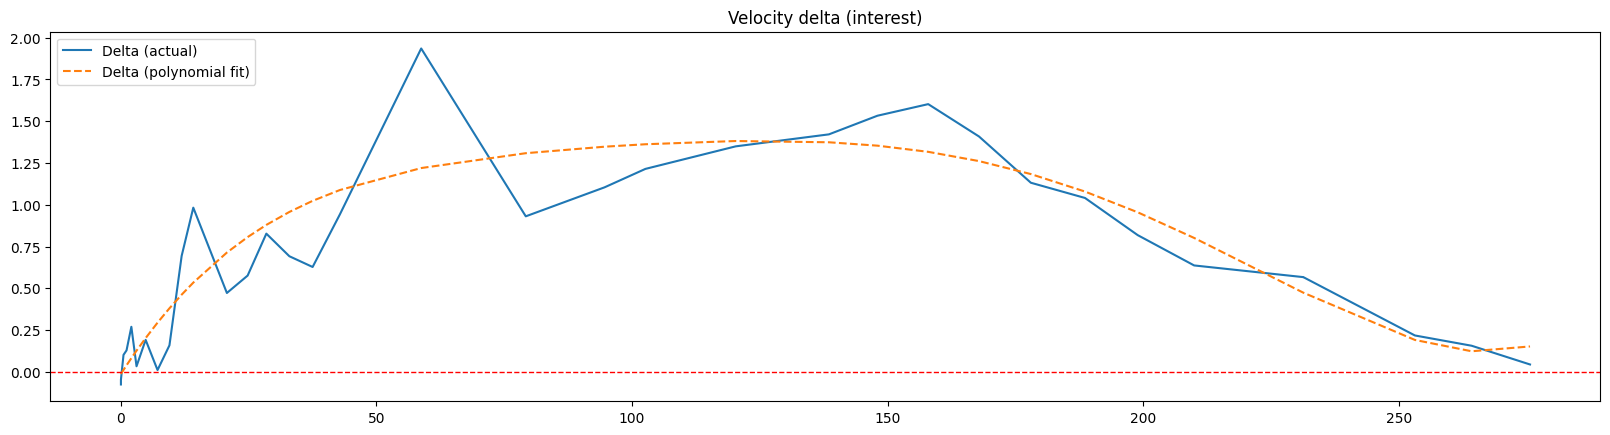

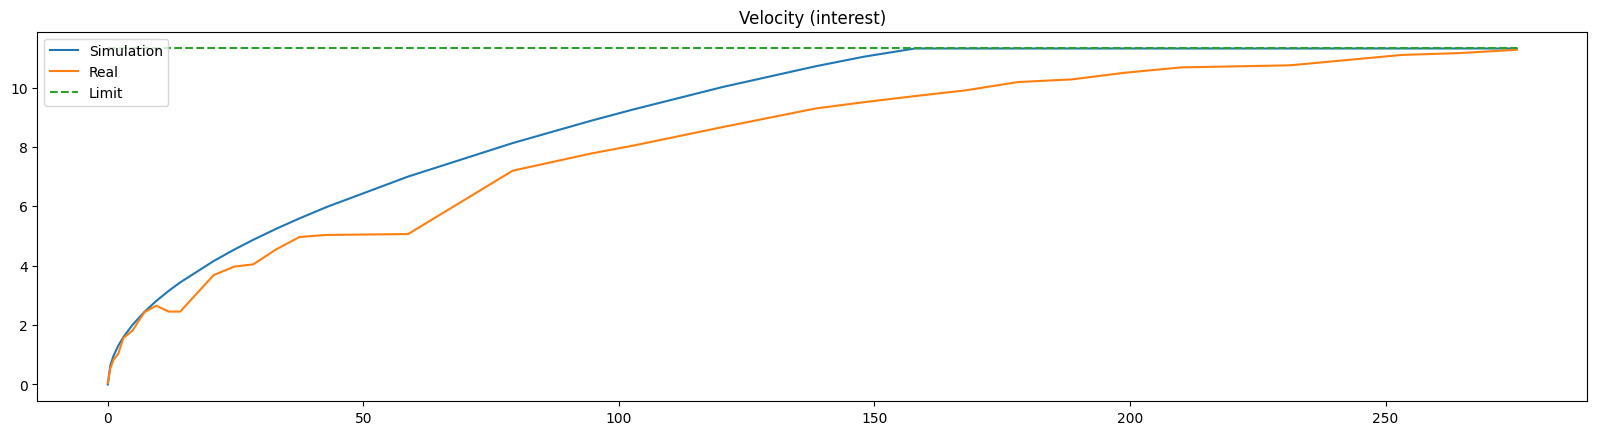

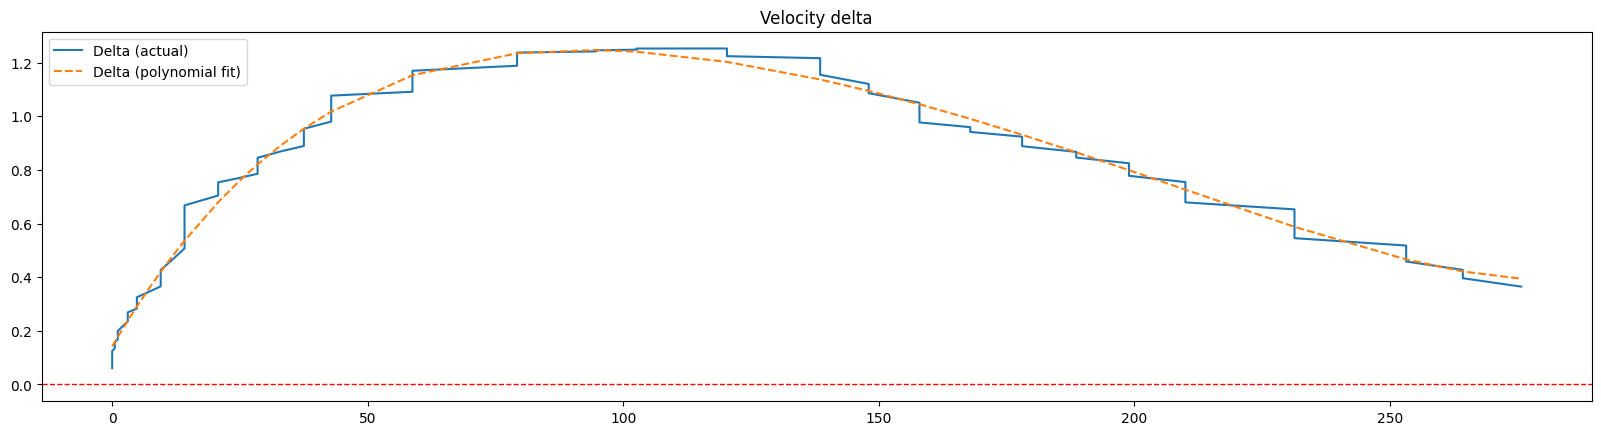

In [52]:
output = draw_init_velocity_delta(
    processed_sections[3]["df"], processed_sections[3]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 105)
)
all_poly_graphs.append(output)

#### Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí

unique velocities in km/h {67.34300537109374, 69.97781524658204, 72.30299606323244, 44.46900329589844, 45.716003036499025, 46.98099975585938, 46.72899742126465, 51.48299789428711, 52.17899894714356, 53.94400405883789, 59.697365570068364}
(0, 330)


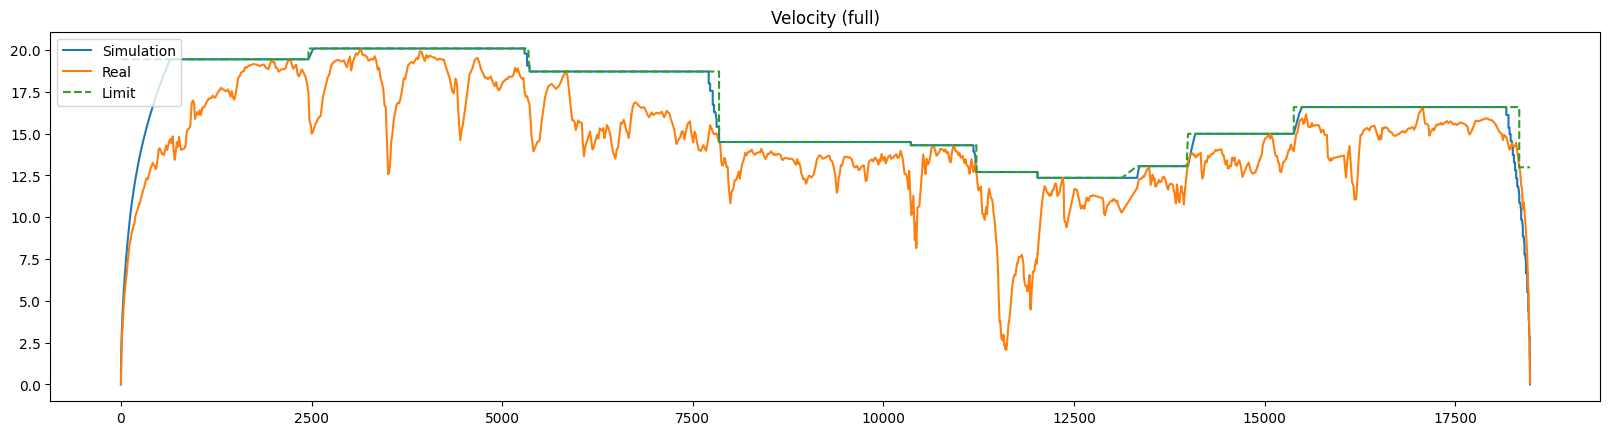

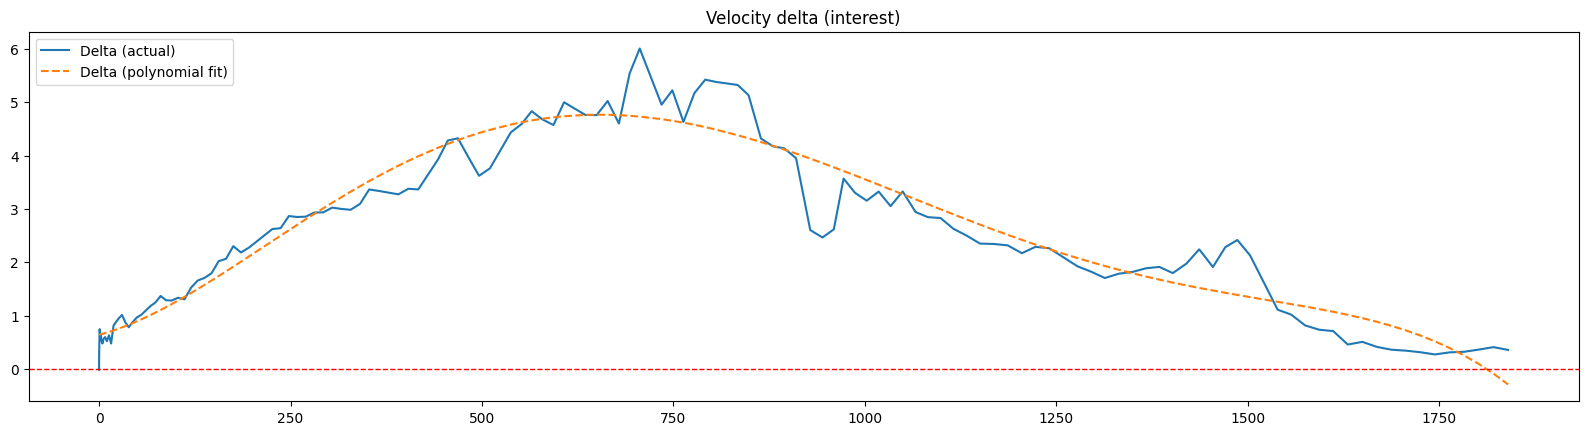

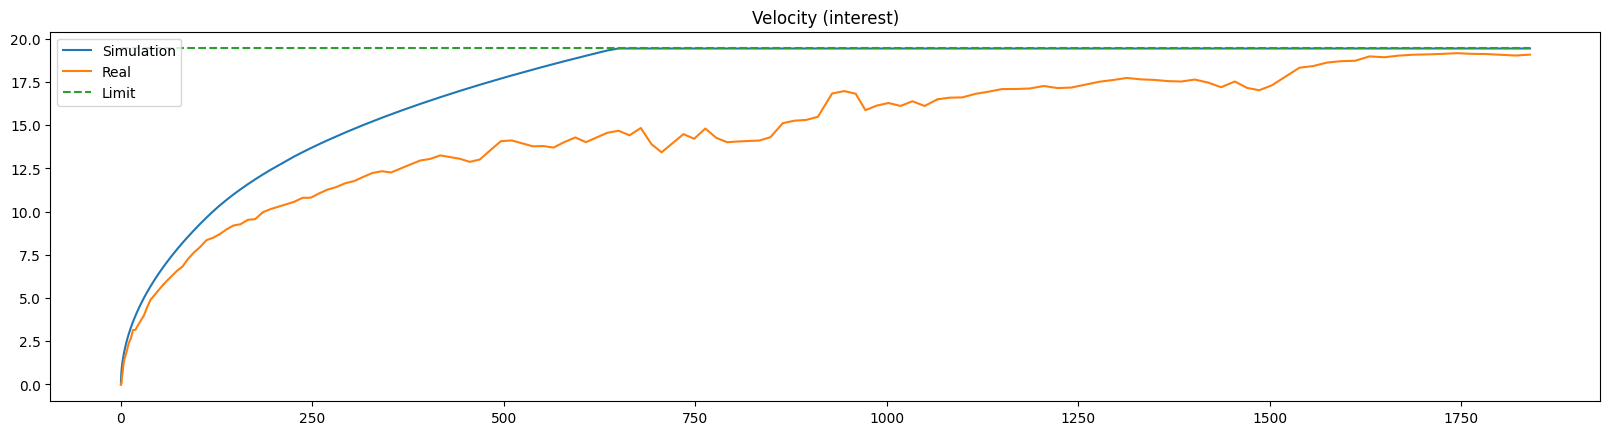

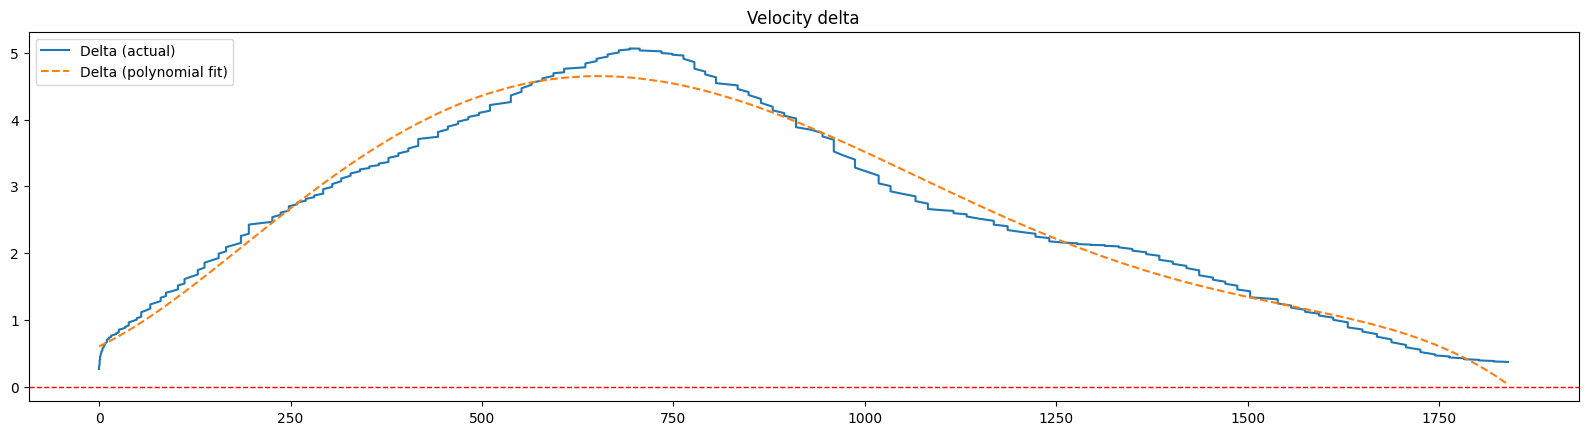

In [53]:
output = draw_init_velocity_delta(
    processed_sections[4]["df"], processed_sections[4]["geojson"],
    filter_window=50, fit_degree=5,
    interest_range=(0, 330)
)
all_poly_graphs.append(output)

#### Sloučení do jednoho grafu

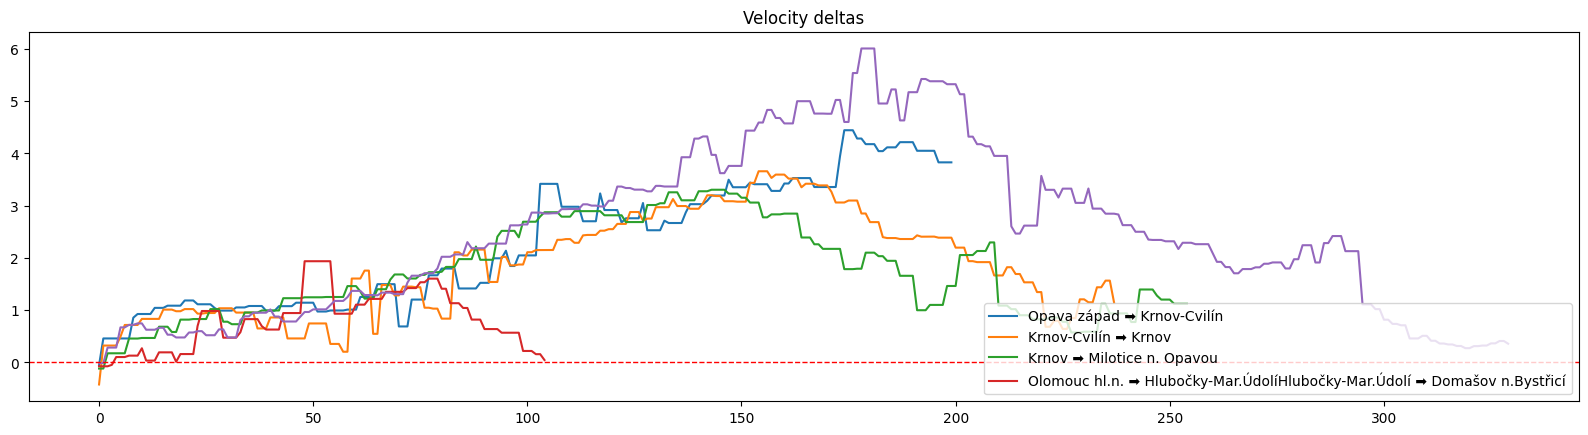

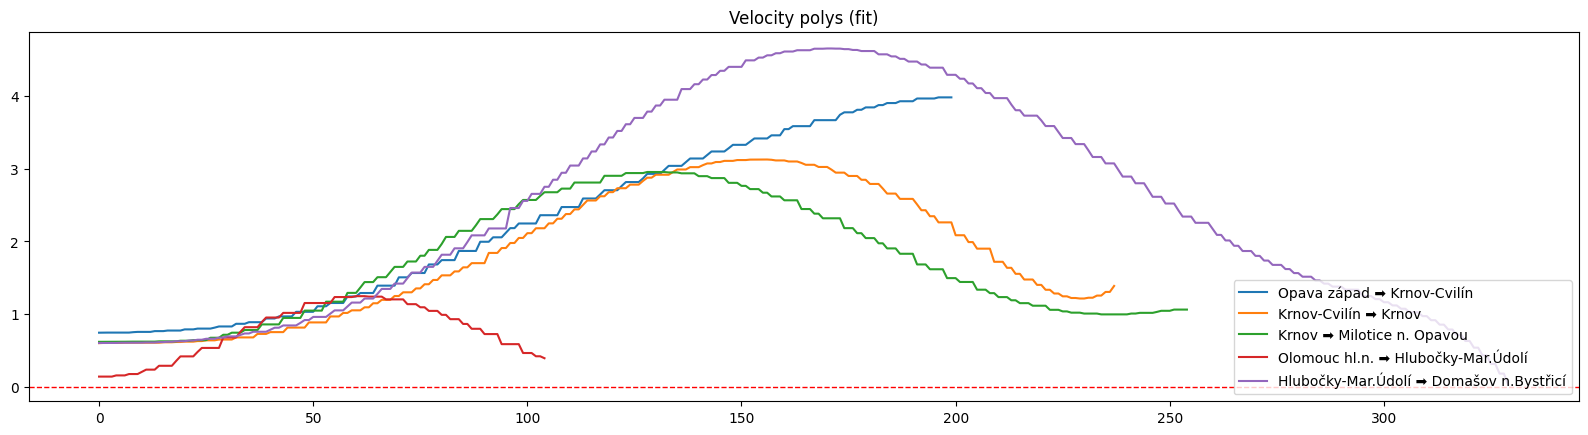

In [55]:
all_velocity_deltas = [x["deltas"] for x in all_poly_graphs]
all_polys = [list(x["poly"](x["dists"])) for x in all_poly_graphs]

max_len = max([len(x) for x in all_velocity_deltas])
for i,x in enumerate(all_velocity_deltas):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))
for i,x in enumerate(all_polys):
    if len(x) < max_len:
        x += [None] * (max_len-len(x))

render_plot(
    "Velocity deltas",
    list(range(0, max_len)),
    all_velocity_deltas,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí"
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)

render_plot(
    "Velocity polys (fit)",
    list(range(0, max_len)),
    all_polys,
    [
        "Opava západ ➡️ Krnov-Cvilín",
        "Krnov-Cvilín ➡️ Krnov",
        "Krnov ➡️ Milotice n. Opavou",
        "Olomouc hl.n. ➡️ Hlubočky-Mar.Údolí",
        "Hlubočky-Mar.Údolí ➡️ Domašov n.Bystřicí"
    ],
    ["solid"]*100,
    show_hline=True,
    legend_loc="lower right"
)